In [457]:
%matplotlib inline

import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import preprocessing

import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.ensemble import VotingClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [458]:
fundamentals = pd.read_csv('fundamentals.csv',index_col = 0)
price_split=pd.read_csv('prices-split-adjusted.csv')
securities = pd.read_csv('securities.csv')
sectors = securities['GICS Sector'].unique()
sub_industry = securities['GICS Sub Industry'].unique()
accounts = fundamentals.columns.values[2:]

In [459]:
fundamentals = fundamentals.rename(columns={'Period Ending': 'date'})

In [460]:
fundamentals = fundamentals.rename(columns={'Ticker Symbol': 'symbol'})

In [461]:
new_data=pd.merge(fundamentals, price_split, on='date', how='left')

In [462]:
new_data1=new_data[new_data["symbol_x"]==new_data["symbol_y"]]

In [463]:
new_data1.drop(['symbol_y'], axis=1,inplace=True)

In [464]:
new_data1=new_data1.rename(columns={'symbol_x':'symbol'})

In [465]:
securities=securities.rename(columns={'Ticker symbol':'symbol'})

In [466]:
new_data2=pd.merge(new_data1, securities, on='symbol', how='left')

In [467]:
#create the For year column again to get rid of null values
new_data2['For Year']=new_data2.date.str.split("-",expand=True,)[0]

In [468]:
#drop Equity Earnings/Loss Unconsolidated Subsidiary because 60% of the data is zero??
#new_data2[new_data2['Equity Earnings/Loss Unconsolidated Subsidiary']==0]
new_data2.drop(['CIK','Security','SEC filings','Date first added','Equity Earnings/Loss Unconsolidated Subsidiary','Address of Headquarters'], axis=1,inplace=True)


In [469]:
new_data2['PE'] = new_data2['close'] / new_data2['Earnings Per Share']

In [470]:
import warnings
warnings.filterwarnings("ignore")

new_data2['date']=pd.to_datetime(new_data2['date'])

In [471]:
#missing EPS and shares outstanding valuses as zero because its possible the company wasnt public
new_data2[['Earnings Per Share']] = new_data2[['Earnings Per Share']].fillna(value=0)
new_data2[['Estimated Shares Outstanding']] = new_data2[['Estimated Shares Outstanding']].fillna(value=0)
new_data2[['PE']] = new_data2[['PE']].fillna(value=0)

In [472]:
#negative P/E ratio indicates low earnings/profit
new_data2['trend']=np.where(new_data2['PE']>0, '1', '0')

In [473]:
new_data2.isnull().sum()

symbol                                                   0
date                                                     0
Accounts Payable                                         0
Accounts Receivable                                      0
Add'l income/expense items                               0
After Tax ROE                                            0
Capital Expenditures                                     0
Capital Surplus                                          0
Cash Ratio                                             272
Cash and Cash Equivalents                                0
Changes in Inventories                                   0
Common Stocks                                            0
Cost of Revenue                                          0
Current Ratio                                          272
Deferred Asset Charges                                   0
Deferred Liability Charges                               0
Depreciation                                            

In [474]:
new_data2['trend']=np.where(new_data2['PE']>0, '1', '0').astype(int)

In [475]:
print(new_data2.columns.get_loc('symbol'))
print(new_data2.columns.get_loc('For Year'))
print(new_data2.columns.get_loc('date'))
print(new_data2.columns.get_loc('GICS Sector'))
print(new_data2.columns.get_loc('GICS Sub Industry'))

0
74
1
82
83


In [476]:
symbol_list=new_data2['symbol'].tolist()
year_list=new_data2['For Year'].tolist()
date_list=new_data2['date'].tolist()
sector_list=new_data2['GICS Sector'].tolist()
sub_industry_list=new_data2['GICS Sub Industry'].tolist()

In [477]:
# Add back the columns later
new_data2.drop(['symbol','For Year','date','GICS Sector','GICS Sub Industry'], axis=1,inplace=True)

In [478]:
#use knn to fill in the missing values of cash,quick and current ratios
import sys
from impyute.imputation.cs import fast_knn
sys.setrecursionlimit(100000) #Increase the recursion limit of the OS

# start the KNN training
fastknn_data=fast_knn(new_data2.values, k=30)

In [479]:
new_data2 = pd.DataFrame.from_records(fastknn_data, columns = new_data2.columns)
new_data2.head()

,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,Changes in Inventories,Common Stocks,...,Treasury Stock,Earnings Per Share,Estimated Shares Outstanding,open,close,low,high,volume,PE,trend
0,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,1.330000e+09,0.0,127000000.0,...,-367000000.0,-5.60,3.350000e+08,12.850000,13.500000,12.840000,13.680000,7005600.0,-2.410714,0.0
1,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,2.175000e+09,0.0,5000000.0,...,0.0,-11.25,1.630222e+08,24.740000,25.250000,24.629999,25.250000,7166600.0,-2.244444,0.0
2,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,1.768000e+09,0.0,7000000.0,...,0.0,4.02,7.169154e+08,53.900002,53.630001,53.320000,54.639999,10626000.0,13.340796,1.0
3,5.102000e+09,352000000.0,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,1.085000e+09,0.0,6000000.0,...,0.0,11.39,6.681299e+08,42.540001,42.349998,41.830002,42.570000,6788900.0,3.718174,1.0
4,6.448000e+09,681000000.0,-5.400000e+07,92.0,-4.910000e+08,3.671000e+09,144.0,9.595000e+09,-56000000.0,16000000.0,...,-320000000.0,2.58,1.600000e+09,52.990002,52.810001,52.360001,53.060001,3019700.0,20.468993,1.0


In [480]:
#add back the columns to the dataframe
new_data2.insert(loc=0, column='symbol', value=symbol_list)
new_data2.insert(loc=74, column='For Year', value=year_list)
new_data2.insert(loc=1, column='date', value=date_list)
new_data2.insert(loc=82, column='GICS Sector', value=sector_list)
new_data2.insert(loc=83, column='GICS Sub Industry', value=sub_industry_list)

In [481]:
new_data2['date']=pd.to_datetime(new_data2['date'])

In [482]:
for col in ['GICS Sector','GICS Sub Industry']:
    new_data2[col] = new_data2[col].astype('category')
for col in ['GICS Sector','GICS Sub Industry']:
    new_data2[col] = new_data2[col].cat.codes

In [483]:
new_data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1357 entries, 0 to 1356
Data columns (total 86 columns):
symbol                                                 1357 non-null object
date                                                   1357 non-null datetime64[ns]
Accounts Payable                                       1357 non-null float64
Accounts Receivable                                    1357 non-null float64
Add'l income/expense items                             1357 non-null float64
After Tax ROE                                          1357 non-null float64
Capital Expenditures                                   1357 non-null float64
Capital Surplus                                        1357 non-null float64
Cash Ratio                                             1357 non-null float64
Cash and Cash Equivalents                              1357 non-null float64
Changes in Inventories                                 1357 non-null float64
Common Stocks                           

In [484]:
new_data2.shape

(1357, 86)

In [485]:
#save For Classification and Regression Problems
new_data2.to_csv('final_merged_data.csv',date_format='%Y-%m-%d')

### PCA

In [486]:
new_data3=new_data2.iloc[:,2:87]

In [487]:
new_data3.head()

,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,Changes in Inventories,Common Stocks,...,Estimated Shares Outstanding,open,close,low,high,volume,GICS Sector,GICS Sub Industry,PE,trend
0,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,1.330000e+09,0.0,127000000.0,...,3.350000e+08,12.850000,13.500000,12.840000,13.680000,7005600.0,5,4,-2.410714,0.0
1,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,2.175000e+09,0.0,5000000.0,...,1.630222e+08,24.740000,25.250000,24.629999,25.250000,7166600.0,5,4,-2.244444,0.0
2,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,1.768000e+09,0.0,7000000.0,...,7.169154e+08,53.900002,53.630001,53.320000,54.639999,10626000.0,5,4,13.340796,1.0
3,5.102000e+09,352000000.0,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,1.085000e+09,0.0,6000000.0,...,6.681299e+08,42.540001,42.349998,41.830002,42.570000,6788900.0,5,4,3.718174,1.0
4,6.448000e+09,681000000.0,-5.400000e+07,92.0,-4.910000e+08,3.671000e+09,144.0,9.595000e+09,-56000000.0,16000000.0,...,1.600000e+09,52.990002,52.810001,52.360001,53.060001,3019700.0,4,87,20.468993,1.0


In [488]:
pca_data = new_data3.drop(['open', 'low', 'high'], axis=1)

In [489]:
def fit_pca(df, n_components):
    pca = PCA(n_components)
    pca.fit(df)   
    return pca

In [490]:
pca_naive = fit_pca(pca_data, n_components=20)

In [491]:
def plot_naive_variance(pca):
    fig, ax = plt.subplots(figsize=(10,6))

    ax.set_xlabel('Dimension #')
    ax.set_ylabel('Explained Variance Ratio')
    ax.set_title('Fraction of Explained Variance')
    ax.plot(pca.explained_variance_ratio_)

    return ax

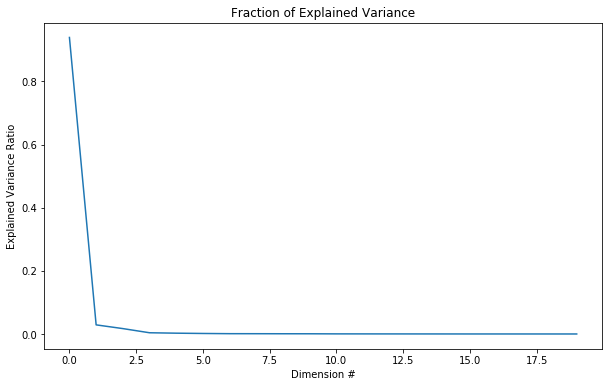

In [492]:
naive_var = plot_naive_variance(pca_naive)

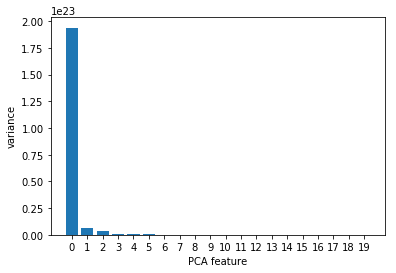

In [493]:
features = range(pca_naive.n_components_)
plt.bar(features, pca_naive.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

### Standardized data

In [494]:
def standardize(df):
    stscaler = StandardScaler().fit(df)
    scaled = stscaler.transform(df)    
    return scaled

In [495]:
scaled = standardize(pca_data)

In [496]:
pca = fit_pca(scaled, n_components=20)

In [497]:
def plot_scaled_variance(pca):
    fig, ax = plt.subplots(figsize=(10,6))

    ax.set_xlabel('Dimension #')
    ax.set_ylabel('Explained Variance Ratio')
    ax.set_title('Fraction of Explained Variance')
    ax.plot(pca.explained_variance_ratio_)
       
    return ax

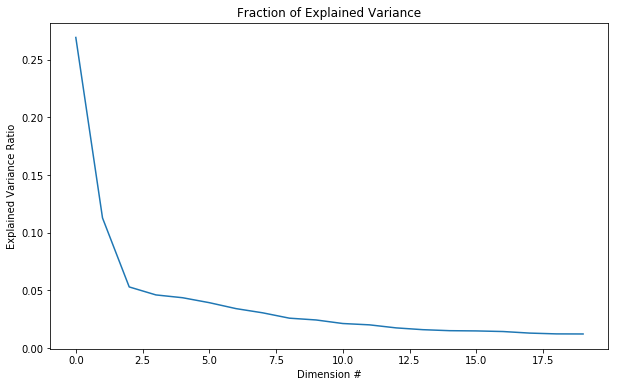

In [498]:
ax = plot_scaled_variance(pca)

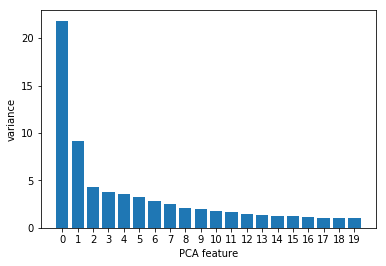

In [499]:
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

In [500]:
vars = pca.explained_variance_ratio_
c_names = ['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10']

print('Variance:  Projected dimension')
print('------------------------------')
for idx, row in enumerate(pca.components_):
    output = '{0:4.1f}%:    '.format(100.0 * vars[idx])
    output += " + ".join("{0:5.2f} * {1:s}".format(val, name) for val, name in zip(row, c_names))
    print(output)

Variance:  Projected dimension
------------------------------
26.9%:     0.18 * f1 +  0.02 * f2 +  0.06 * f3 + -0.01 * f4 + -0.12 * f5 +  0.13 * f6 + -0.01 * f7 +  0.15 * f8 + -0.03 * f9 +  0.10 * f10
11.3%:    -0.11 * f1 + -0.04 * f2 +  0.09 * f3 + -0.00 * f4 + -0.19 * f5 + -0.07 * f6 + -0.03 * f7 + -0.22 * f8 + -0.08 * f9 + -0.08 * f10
 5.3%:    -0.02 * f1 +  0.17 * f2 + -0.01 * f3 +  0.07 * f4 + -0.07 * f5 +  0.10 * f6 +  0.06 * f7 + -0.06 * f8 +  0.04 * f9 +  0.02 * f10
 4.6%:     0.02 * f1 +  0.16 * f2 + -0.06 * f3 + -0.08 * f4 +  0.09 * f5 + -0.04 * f6 + -0.16 * f7 + -0.02 * f8 + -0.04 * f9 +  0.04 * f10
 4.4%:    -0.00 * f1 + -0.07 * f2 + -0.07 * f3 + -0.01 * f4 +  0.16 * f5 + -0.02 * f6 +  0.35 * f7 + -0.01 * f8 + -0.02 * f9 +  0.17 * f10
 3.9%:     0.01 * f1 +  0.15 * f2 +  0.15 * f3 +  0.02 * f4 +  0.01 * f5 + -0.10 * f6 +  0.19 * f7 +  0.06 * f8 +  0.03 * f9 + -0.03 * f10
 3.4%:    -0.11 * f1 +  0.11 * f2 +  0.03 * f3 + -0.05 * f4 + -0.02 * f5 +  0.12 * f6 +  0.19 * f7 + -0.

In [501]:
# 83.5% are explained by PCA 20 features
26.9+11.3+5.3+4.6+4.4+3.9+3.4+3.1+2.6+2.4+2.1+2+1.8+1.6+1.5+1.5+1.4+1.3+1.2+1.2


83.5

In [502]:
reduced = pca.transform(scaled)

In [503]:
scaled.shape

(1357, 81)

In [504]:
reduced.shape

(1357, 20)

In [505]:
new_data2.to_csv('reduced.csv')

In [506]:
# Troy, please use "reduced" to run clustering. 
# Feel free to edit the PCA part, we can drop more columns when create "pca_data".

### Clustering

In [507]:
data00=new_data2.copy()

In [508]:
data00

,symbol,date,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,...,Estimated Shares Outstanding,open,close,low,high,volume,GICS Sector,GICS Sub Industry,PE,trend
0,AAL,2012-12-31,3.068000e+09,-2.220000e+08,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.000000,1.330000e+09,...,3.350000e+08,12.850000,13.500000,12.840000,13.680000,7005600.0,5,4,-2.410714,0.0
1,AAL,2013-12-31,4.975000e+09,-9.300000e+07,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.000000,2.175000e+09,...,1.630222e+08,24.740000,25.250000,24.629999,25.250000,7166600.0,5,4,-2.244444,0.0
2,AAL,2014-12-31,4.668000e+09,-1.600000e+08,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.000000,1.768000e+09,...,7.169154e+08,53.900002,53.630001,53.320000,54.639999,10626000.0,5,4,13.340796,1.0
3,AAL,2015-12-31,5.102000e+09,3.520000e+08,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.000000,1.085000e+09,...,6.681299e+08,42.540001,42.349998,41.830002,42.570000,6788900.0,5,4,3.718174,1.0
4,ABBV,2013-12-31,6.448000e+09,6.810000e+08,-5.400000e+07,92.0,-4.910000e+08,3.671000e+09,144.000000,9.595000e+09,...,1.600000e+09,52.990002,52.810001,52.360001,53.060001,3019700.0,4,87,20.468993,1.0
5,ABBV,2014-12-31,6.954000e+09,-1.720000e+08,-6.510000e+08,102.0,-6.120000e+08,4.194000e+09,74.000000,8.348000e+09,...,1.598198e+09,66.720001,65.440002,65.349998,67.099998,3917300.0,4,87,58.954957,1.0
6,ABBV,2015-12-31,8.463000e+09,-1.076000e+09,-2.060000e+08,130.0,-5.320000e+08,1.308000e+10,77.000000,8.399000e+09,...,1.633016e+09,59.500000,59.240002,59.200001,59.930000,6019300.0,4,87,18.806350,1.0
7,ABC,2013-09-30,1.487064e+10,-2.312518e+09,-4.400000e+04,19.0,-2.024500e+08,2.360992e+09,8.000000,1.231006e+09,...,2.306952e+08,60.900002,61.099998,60.689999,61.270000,1040200.0,4,44,32.499999,1.0
8,ABC,2014-09-30,1.725016e+10,-9.382860e+08,-2.859400e+07,14.0,-2.644570e+08,2.749185e+09,10.000000,1.808513e+09,...,2.247787e+08,77.650002,77.300003,77.190002,78.019997,1373500.0,4,44,63.360658,1.0
9,ABC,2015-09-30,2.157823e+10,-1.478793e+09,-4.422000e+07,22.0,-2.315850e+08,3.736477e+09,10.000000,2.167442e+09,...,2.228468e+08,96.080002,94.989998,94.070000,96.680000,2381200.0,4,44,-153.209674,0.0


In [509]:
data2012=data00.loc[data00['For Year'] == '2012']
data2013=data00.loc[data00['For Year'] == '2013']
data2014=data00.loc[data00['For Year'] == '2014']
data2015=data00.loc[data00['For Year'] == '2015']
data2016=data00.loc[data00['For Year'] == '2016']

In [510]:
names2012 = data2012['symbol'].values.tolist()
from collections import OrderedDict
names2012 = list(OrderedDict.fromkeys(names2012))

names2013 = data2013['symbol'].values.tolist()
names2013 = list(OrderedDict.fromkeys(names2013))

names2014 = data2014['symbol'].values.tolist()
names2014 = list(OrderedDict.fromkeys(names2014))

names2015 = data2015['symbol'].values.tolist()
names2015 = list(OrderedDict.fromkeys(names2015))

names2016 = data2016['symbol'].values.tolist()
names2016 = list(OrderedDict.fromkeys(names2016))

In [511]:
data2012 = data2012.drop(['symbol', 'date','For Year','trend'], axis=1)
data2013 = data2013.drop(['symbol', 'date','For Year','trend'], axis=1)
data2014 = data2014.drop(['symbol', 'date','For Year','trend'], axis=1)
data2015 = data2015.drop(['symbol', 'date','For Year','trend'], axis=1)
data2016 = data2016.drop(['symbol', 'date','For Year','trend'], axis=1)

## t-SNE before PCA:

### t-SNE for 2012 before PCA

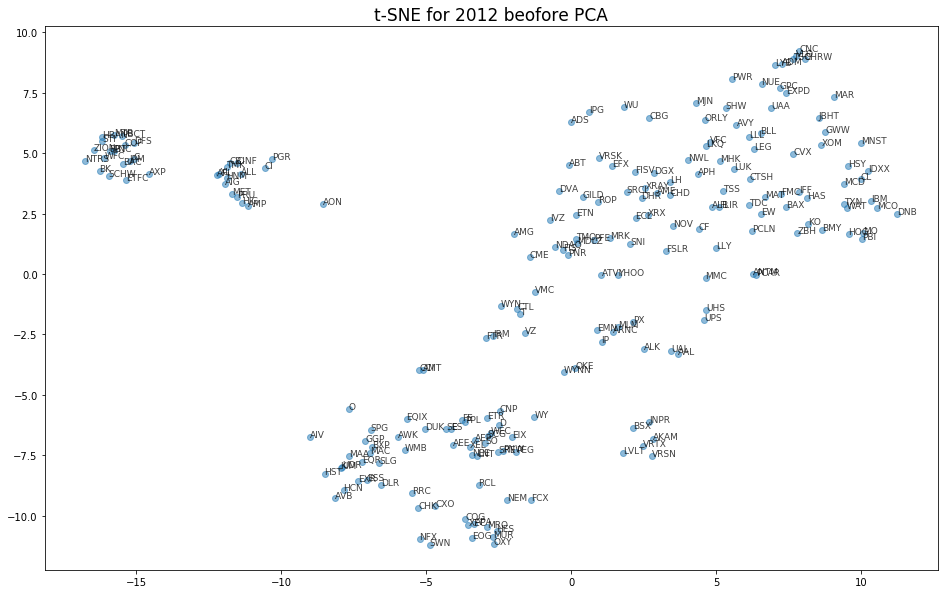

In [512]:
from sklearn.preprocessing import normalize

data2012s = data2012.values
normalized_2012 = normalize(data2012s)

from sklearn.manifold import TSNE

plt.figure(figsize=(16,10))


# Create a TSNE instance: model
model = TSNE(learning_rate=50)

# Apply fit_transform to normalized_movements: tsne_features
tsne_features = model.fit_transform(normalized_2012)

# Select the 0th feature: xs
xs2012 = tsne_features[:,0]

# Select the 1th feature: ys
ys2012 = tsne_features[:,1]

# Scatter plot
plt.scatter(xs2012, ys2012, alpha=0.5)
# Annotate the points
for x0, y0, company in zip(xs2012, ys2012, names2012):
    plt.annotate(company, (x0, y0), fontsize=9, alpha=0.75)
#plt.figure(figsize=(18,20))
plt.title('t-SNE for 2012 beofore PCA',fontsize=17)
plt.show()

### t-SNE for 2013 before PCA

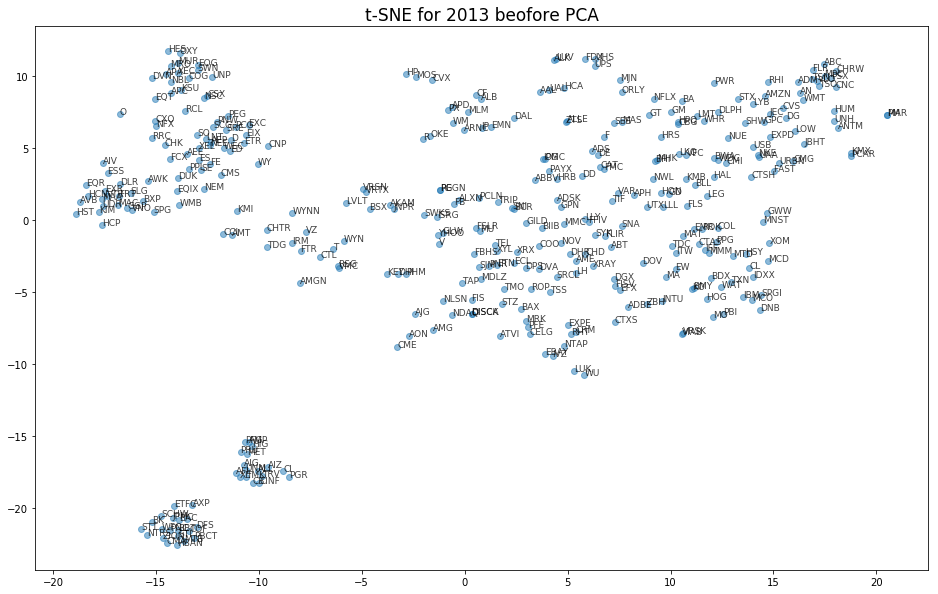

In [570]:
from sklearn.preprocessing import normalize

data2013s = data2013.values
normalized_2013 = normalize(data2013s)

from sklearn.manifold import TSNE

plt.figure(figsize=(16,10))


# Create a TSNE instance: model
model = TSNE(learning_rate=50)

# Apply fit_transform to normalized_movements: tsne_features
tsne_features = model.fit_transform(normalized_2013)

# Select the 0th feature: xs
xs2013 = tsne_features[:,0]

# Select the 1th feature: ys
ys2013 = tsne_features[:,1]

# Scatter plot
plt.scatter(xs2013, ys2013, alpha=0.5)
# Annotate the points
for x1, y1, company in zip(xs2013, ys2013, names2013):
    plt.annotate(company, (x1, y1), fontsize=9, alpha=0.75)
#plt.figure(figsize=(18,20))
plt.title('t-SNE for 2013 beofore PCA',fontsize=17)
plt.show()

### t-SNE for 2014 before PCA

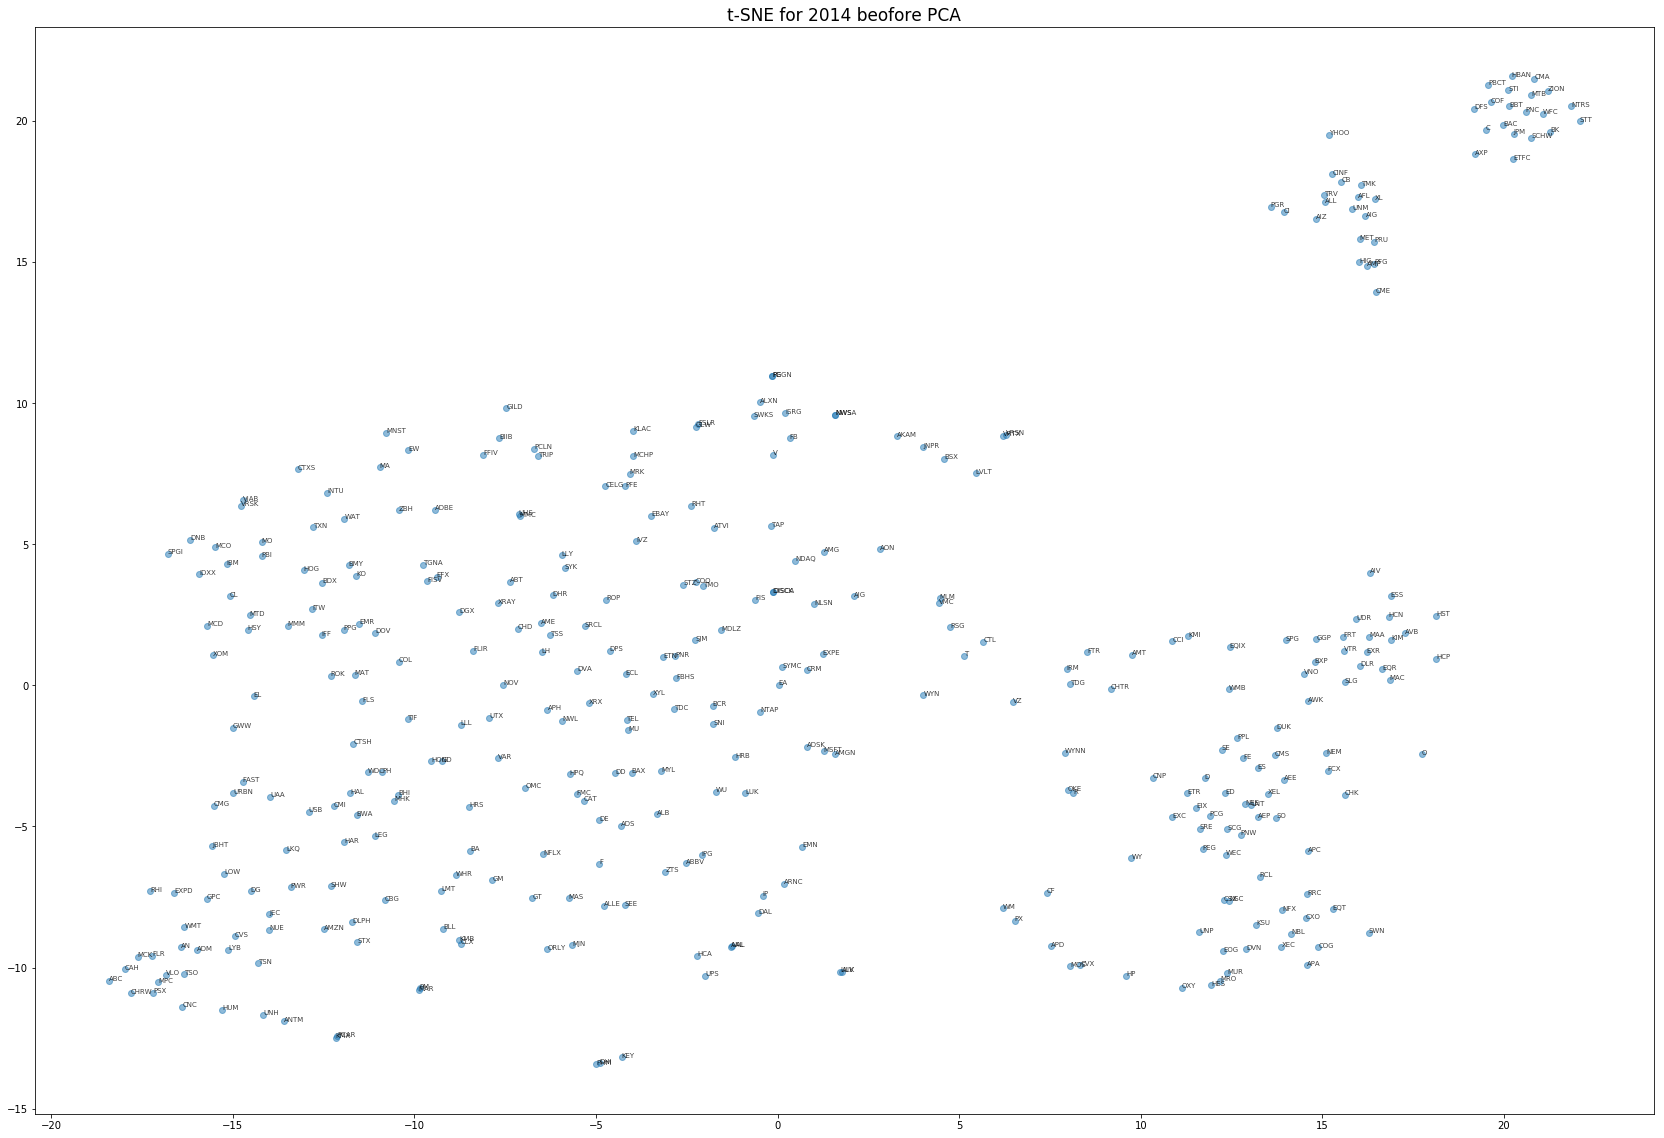

In [567]:
from sklearn.preprocessing import normalize

data2014s = data2014.values
normalized_2014 = normalize(data2014s)

from sklearn.manifold import TSNE

plt.figure(figsize=(16,10))


# Create a TSNE instance: model
model = TSNE(learning_rate=50)

# Apply fit_transform to normalized_movements: tsne_features
tsne_features = model.fit_transform(normalized_2014)

# Select the 0th feature: xs
xs2014 = tsne_features[:,0]

# Select the 1th feature: ys
ys2014 = tsne_features[:,1]

# Scatter plot
plt.scatter(xs2014, ys2014, alpha=0.5)
# Annotate the points
for x2, y2, company in zip(xs2014, ys2014, names2014):
    plt.annotate(company, (x2, y2), fontsize=9, alpha=0.75)
#plt.figure(figsize=(18,20))
plt.title('t-SNE for 2014 beofore PCA',fontsize=17)
plt.show()

### t-SNE for 2015 before PCA

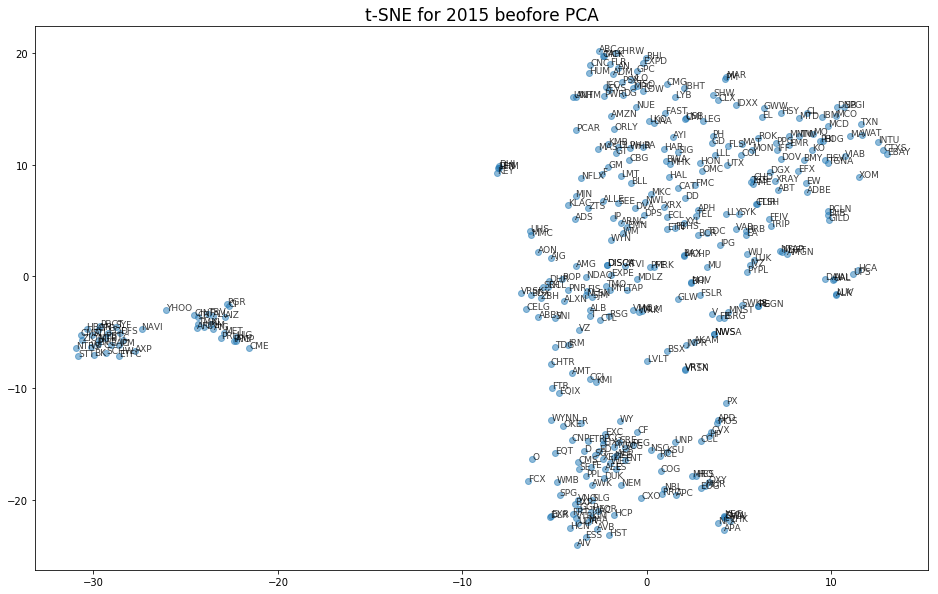

In [515]:
from sklearn.preprocessing import normalize

data2015s = data2015.values
normalized_2015 = normalize(data2015s)

from sklearn.manifold import TSNE

plt.figure(figsize=(16,10))


# Create a TSNE instance: model
model = TSNE(learning_rate=50)

# Apply fit_transform to normalized_movements: tsne_features
tsne_features = model.fit_transform(normalized_2015)

# Select the 0th feature: xs
xs2015 = tsne_features[:,0]

# Select the 1th feature: ys
ys2015 = tsne_features[:,1]

# Scatter plot
plt.scatter(xs2015, ys2015, alpha=0.5)
# Annotate the points
for x3, y3, company in zip(xs2015, ys2015, names2015):
    plt.annotate(company, (x3, y3), fontsize=9, alpha=0.75)
#plt.figure(figsize=(18,20))
plt.title('t-SNE for 2015 beofore PCA',fontsize=17)
plt.show()

### t-SNE for 2016 before PCA

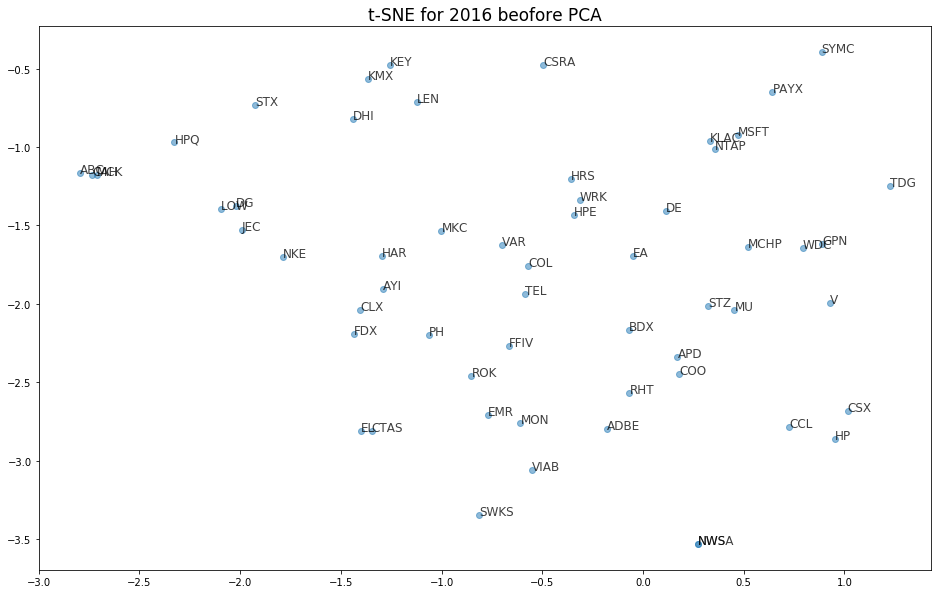

In [516]:
from sklearn.preprocessing import normalize

data2016s = data2016.values
normalized_2016 = normalize(data2016s)

from sklearn.manifold import TSNE

plt.figure(figsize=(16,10))


# Create a TSNE instance: model
model = TSNE(learning_rate=50,perplexity=40)

# Apply fit_transform to normalized_movements: tsne_features
tsne_features = model.fit_transform(normalized_2016)

# Select the 0th feature: xs
xs2016 = tsne_features[:,0]

# Select the 1th feature: ys
ys2016 = tsne_features[:,1]

# Scatter plot
plt.scatter(xs2016, ys2016, alpha=0.5)
# Annotate the points
for x4, y4, company in zip(xs2016, ys2016, names2016):
    plt.annotate(company, (x4, y4), fontsize=12, alpha=0.75)
#plt.figure(figsize=(18,20))
plt.title('t-SNE for 2016 beofore PCA',fontsize=17)
plt.show()

## t-SNE after PCA:

In [517]:
df00=new_data2.copy()

In [518]:
df11 = pd.DataFrame(data=reduced)
#x21 = df11.iloc[:,0:19].values
df11['Year'] = df00['For Year']
df11['symbol']=df00['symbol']
#df11

In [519]:
pca2012=df11.loc[df11['Year'] == '2012']
pca2013=df11.loc[df11['Year'] == '2013']
pca2014=df11.loc[df11['Year'] == '2014']
pca2015=df11.loc[df11['Year'] == '2015']
pca2016=df11.loc[df11['Year'] == '2016']

In [520]:
pcaname2012 = pca2012['symbol'].values.tolist()
from collections import OrderedDict
pcaname2012 = list(OrderedDict.fromkeys(pcaname2012))

pcaname2013 = pca2013['symbol'].values.tolist()
pcaname2013 = list(OrderedDict.fromkeys(pcaname2013))

pcaname2014 = pca2014['symbol'].values.tolist()
pcaname2014 = list(OrderedDict.fromkeys(pcaname2014))

pcaname2015 = pca2015['symbol'].values.tolist()
pcaname2015 = list(OrderedDict.fromkeys(pcaname2015))

pcaname2016 = pca2016['symbol'].values.tolist()
pcaname2016 = list(OrderedDict.fromkeys(pcaname2016))

pca2012 = pca2012.drop(['symbol','Year'], axis=1)
pca2013 = pca2013.drop(['symbol','Year'], axis=1)
pca2014 = pca2014.drop(['symbol','Year'], axis=1)
pca2015 = pca2015.drop(['symbol','Year'], axis=1)
pca2016 = pca2016.drop(['symbol','Year'], axis=1)
#pcaname2012

### t-SNE for 2012 after PCA

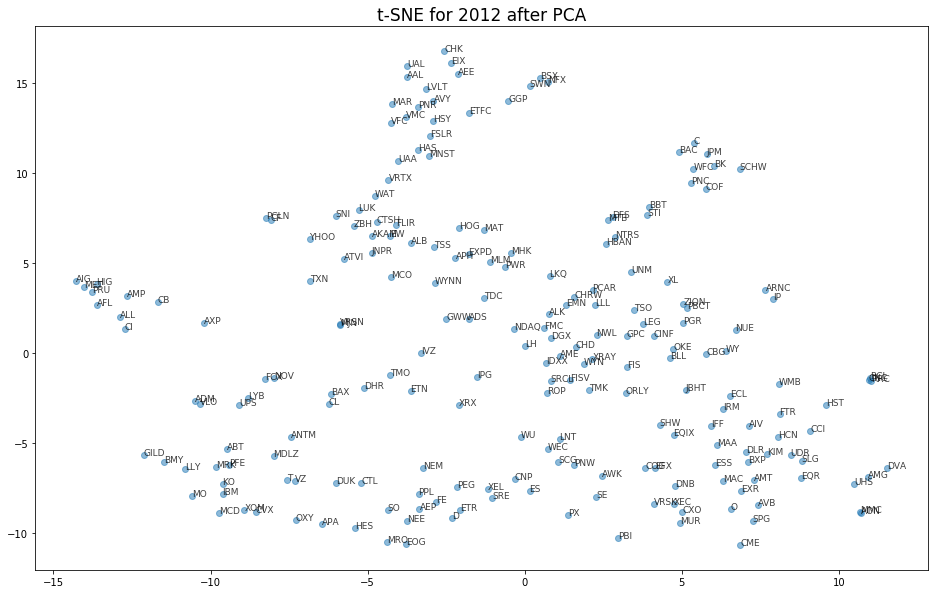

In [521]:
from sklearn.preprocessing import normalize

pca2012s = pca2012.values
normalized_2012pca = normalize(pca2012s)

from sklearn.manifold import TSNE

plt.figure(figsize=(16,10))


# Create a TSNE instance: model
model = TSNE(learning_rate=50)

# Apply fit_transform to normalized_movements: tsne_features
tsne_features = model.fit_transform(normalized_2012pca)

# Select the 0th feature: xs
xs2012pca = tsne_features[:,0]

# Select the 1th feature: ys
ys2012pca = tsne_features[:,1]

# Scatter plot
plt.scatter(xs2012pca, ys2012pca, alpha=0.5)
# Annotate the points
for x00, y00, company in zip(xs2012pca, ys2012pca, pcaname2012):
    plt.annotate(company, (x00, y00), fontsize=9, alpha=0.75)
#plt.figure(figsize=(18,20))
plt.title('t-SNE for 2012 after PCA',fontsize=17)
plt.show()

### t-SNE for 2013 after PCA

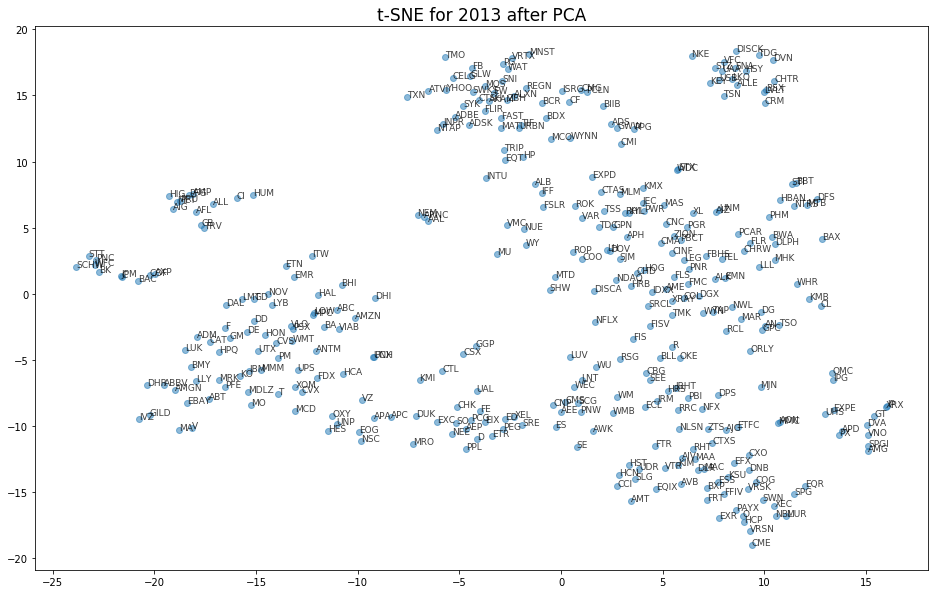

In [571]:
pca2013s = pca2013.values
normalized_2013pca = normalize(pca2013s)

plt.figure(figsize=(16,10))


# Create a TSNE instance: model
model = TSNE(learning_rate=50)

# Apply fit_transform to normalized_movements: tsne_features
tsne_features = model.fit_transform(normalized_2013pca)

# Select the 0th feature: xs
xs2013pca = tsne_features[:,0]

# Select the 1th feature: ys
ys2013pca = tsne_features[:,1]

# Scatter plot
plt.scatter(xs2013pca, ys2013pca, alpha=0.5)
# Annotate the points
for x11, y11, company in zip(xs2013pca, ys2013pca, pcaname2013):
    plt.annotate(company, (x11, y11), fontsize=9, alpha=0.75)
#plt.figure(figsize=(18,20))
plt.title('t-SNE for 2013 after PCA',fontsize=17)
plt.show()

### t-SNE for 2014 after PCA

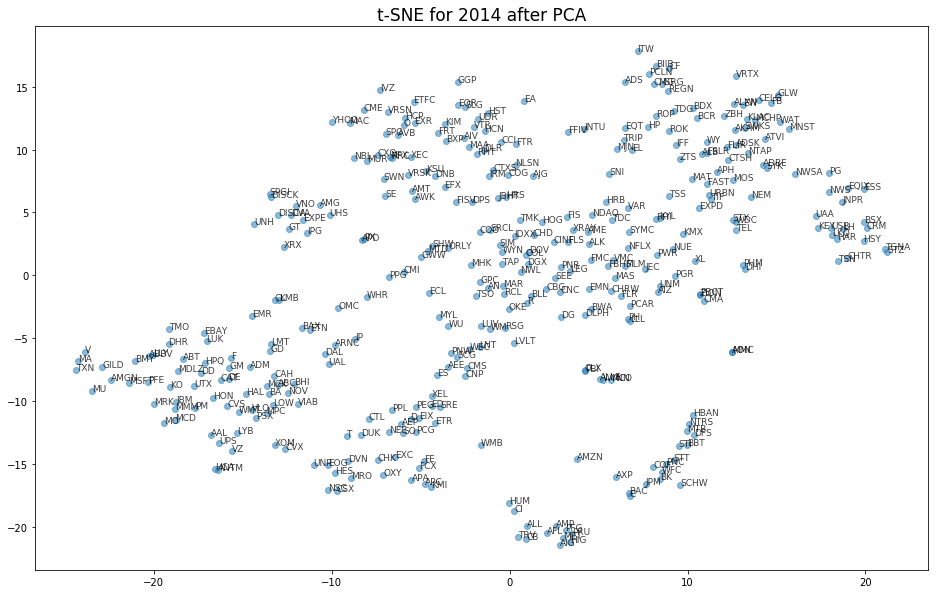

In [523]:
pca2014s = pca2014.values
normalized_2014pca = normalize(pca2014s)

plt.figure(figsize=(16,10))


# Create a TSNE instance: model
model = TSNE(learning_rate=50)

# Apply fit_transform to normalized_movements: tsne_features
tsne_features = model.fit_transform(normalized_2014pca)

# Select the 0th feature: xs
xs2014pca = tsne_features[:,0]

# Select the 1th feature: ys
ys2014pca = tsne_features[:,1]

# Scatter plot
plt.scatter(xs2014pca, ys2014pca, alpha=0.5)
# Annotate the points
for x22, y22, company in zip(xs2014pca, ys2014pca, pcaname2014):
    plt.annotate(company, (x22, y22), fontsize=9, alpha=0.75)
#plt.figure(figsize=(18,20))
plt.title('t-SNE for 2014 after PCA',fontsize=17)
plt.show()

### t-SNE for 2015 after PCA

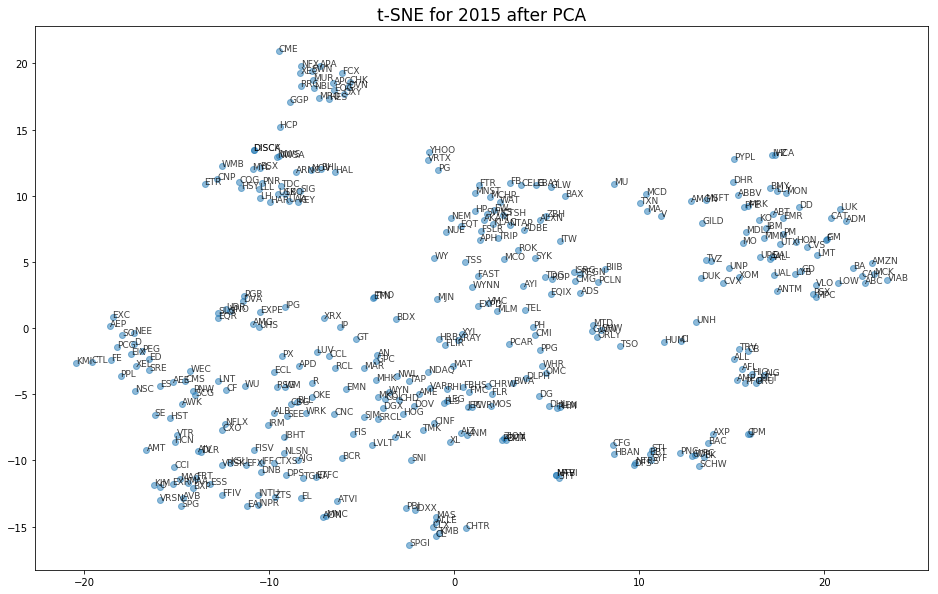

In [524]:
pca2015s = pca2015.values
normalized_2015pca = normalize(pca2015s)

plt.figure(figsize=(16,10))


# Create a TSNE instance: model
model = TSNE(learning_rate=50)

# Apply fit_transform to normalized_movements: tsne_features
tsne_features = model.fit_transform(normalized_2015pca)

# Select the 0th feature: xs
xs2015pca = tsne_features[:,0]

# Select the 1th feature: ys
ys2015pca = tsne_features[:,1]

# Scatter plot
plt.scatter(xs2015pca, ys2015pca, alpha=0.5)
# Annotate the points
for x33, y33, company in zip(xs2015pca, ys2015pca, pcaname2015):
    plt.annotate(company, (x33, y33), fontsize=9, alpha=0.75)
#plt.figure(figsize=(18,20))
plt.title('t-SNE for 2015 after PCA',fontsize=17)
plt.show()

### t-SNE for 2016 after PCA

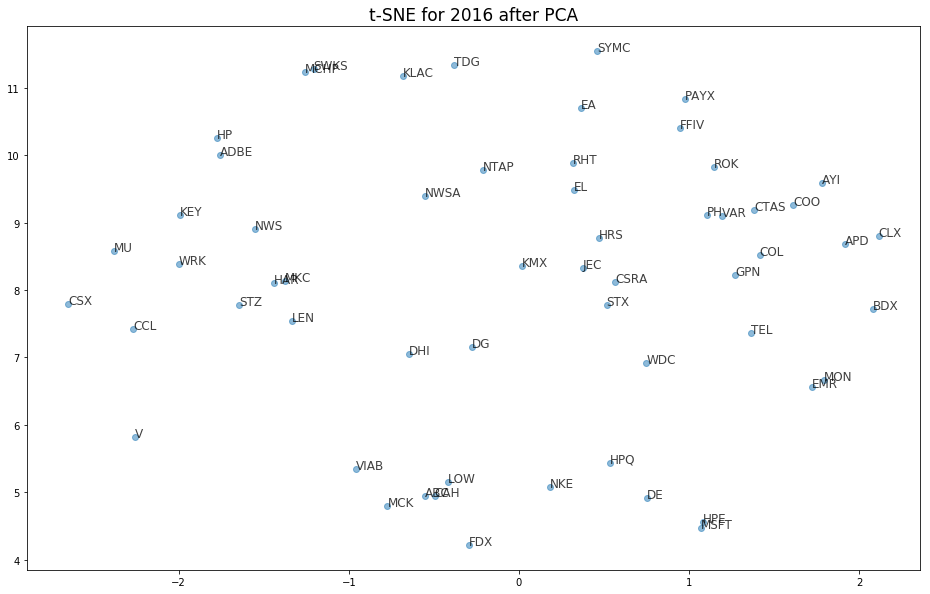

In [525]:
pca2016s = pca2016.values
normalized_2016pca = normalize(pca2016s)

plt.figure(figsize=(16,10))


# Create a TSNE instance: model
model = TSNE(learning_rate=50)

# Apply fit_transform to normalized_movements: tsne_features
tsne_features = model.fit_transform(normalized_2016pca)

# Select the 0th feature: xs
xs2016pca = tsne_features[:,0]

# Select the 1th feature: ys
ys2016pca = tsne_features[:,1]

# Scatter plot
plt.scatter(xs2016pca, ys2016pca, alpha=0.5)
# Annotate the points
for x44, y44, company in zip(xs2016pca, ys2016pca, pcaname2016):
    plt.annotate(company, (x44, y44), fontsize=12, alpha=0.75)
#plt.figure(figsize=(18,20))
plt.title('t-SNE for 2016 after PCA',fontsize=17)
plt.show()

## K-means before PCA

### K-means for 2012 before PCA

In [526]:
#import needed libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

x2012 = data2012.iloc[:,0:82].values

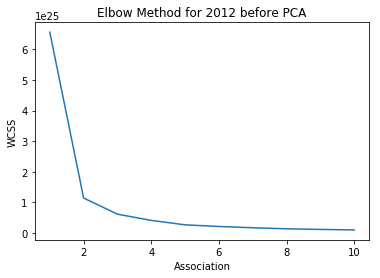

In [527]:
#Let's select the optimum number of clusters for k-means classification
from sklearn.cluster import KMeans
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                    max_iter = 400, n_init = 10, random_state = 0)
    kmeans.fit(x2012)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for 2012 before PCA')
plt.xlabel('Association')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

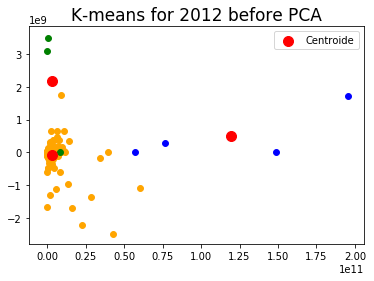

In [528]:
#k = 3
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 500, 
                n_init = 10, random_state = 0)
y_kmeans2012 = kmeans.fit_predict(x2012)

plt.scatter(x2012[y_kmeans2012 == 0, 0], x2012[y_kmeans2012 == 0, 1], s = 35, 
            c = 'orange')
plt.scatter(x2012[y_kmeans2012 == 1, 0], x2012[y_kmeans2012 == 1, 1], s = 35, 
            c = 'blue')
plt.scatter(x2012[y_kmeans2012 == 2, 0], x2012[y_kmeans2012 == 2, 1], s = 35, 
            c = 'green')
#plt.scatter(x[y_kmeans == 3, 0], x[y_kmeans == 3, 1], s = 35, 
#            c = 'orange')

#Plotting the centroids of the clusters
plt.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:,1], s = 100, 
            c = 'red', label = 'Centroide')
plt.title('K-means for 2012 before PCA',fontsize=17)
plt.legend()

### K-means for 2013 before PCA

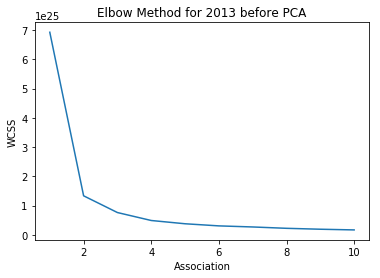

In [529]:
x2013 = data2013.iloc[:,0:82].values
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                    max_iter = 400, n_init = 10, random_state = 0)
    kmeans.fit(x2013)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for 2013 before PCA')
plt.xlabel('Association')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

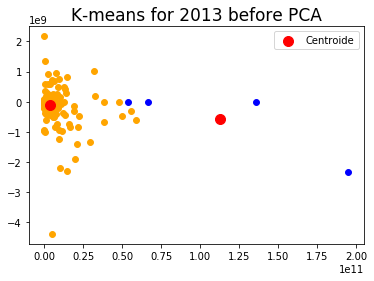

In [530]:
#k = 2
kmeans = KMeans(n_clusters = 2, init = 'k-means++', max_iter = 500, 
                n_init = 10, random_state = 0)
y_kmeans2013 = kmeans.fit_predict(x2013)

plt.scatter(x2013[y_kmeans2013 == 0, 0], x2013[y_kmeans2013 == 0, 1], s = 35, 
            c = 'orange')
plt.scatter(x2013[y_kmeans2013 == 1, 0], x2013[y_kmeans2013 == 1, 1], s = 35, 
            c = 'blue')


#Plotting the centroids of the clusters
plt.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:,1], s = 100, 
            c = 'red', label = 'Centroide')
plt.title('K-means for 2013 before PCA',fontsize=17)
plt.legend()

### K-means for 2014 before PCA

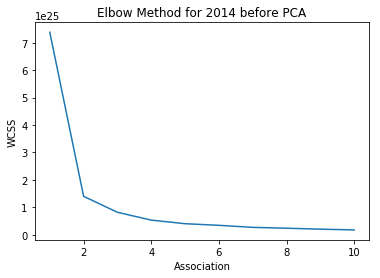

In [531]:
x2014 = data2014.iloc[:,0:82].values
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                    max_iter = 400, n_init = 10, random_state = 0)
    kmeans.fit(x2014)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for 2014 before PCA')
plt.xlabel('Association')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

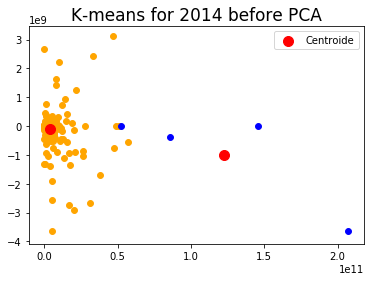

In [532]:
#k = 2
kmeans = KMeans(n_clusters = 2, init = 'k-means++', max_iter = 500, 
                n_init = 10, random_state = 0)
y_kmeans2014 = kmeans.fit_predict(x2014)

plt.scatter(x2014[y_kmeans2014 == 0, 0], x2014[y_kmeans2014 == 0, 1], s = 35, 
            c = 'orange')
plt.scatter(x2014[y_kmeans2014 == 1, 0], x2014[y_kmeans2014 == 1, 1], s = 35, 
            c = 'blue')


#Plotting the centroids of the clusters
plt.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:,1], s = 100, 
            c = 'red', label = 'Centroide')
plt.title('K-means for 2014 before PCA',fontsize=17)
plt.legend()

### K-means for 2015 before PCA

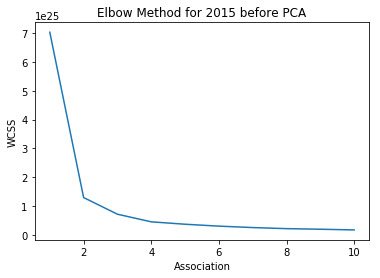

In [533]:
x2015 = data2015.iloc[:,0:82].values
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                    max_iter = 400, n_init = 10, random_state = 0)
    kmeans.fit(x2015)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for 2015 before PCA')
plt.xlabel('Association')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

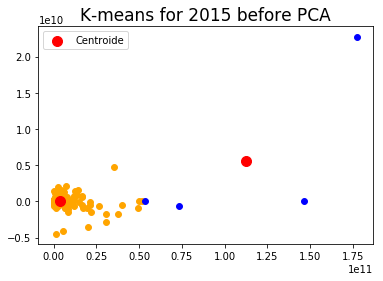

In [534]:
#k = 2
kmeans = KMeans(n_clusters = 2, init = 'k-means++', max_iter = 500, 
                n_init = 10, random_state = 0)
y_kmeans2015 = kmeans.fit_predict(x2015)

plt.scatter(x2015[y_kmeans2015 == 0, 0], x2015[y_kmeans2015 == 0, 1], s = 35, 
            c = 'orange')
plt.scatter(x2015[y_kmeans2015 == 1, 0], x2015[y_kmeans2015 == 1, 1], s = 35, 
            c = 'blue')


#Plotting the centroids of the clusters
plt.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:,1], s = 100, 
            c = 'red', label = 'Centroide')
plt.title('K-means for 2015 before PCA',fontsize=17)
plt.legend()

### K-means for 2016 before PCA

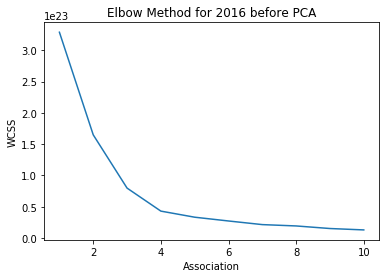

In [535]:
x2016 = data2016.iloc[:,0:82].values
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                    max_iter = 400, n_init = 10, random_state = 0)
    kmeans.fit(x2016)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for 2016 before PCA')
plt.xlabel('Association')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

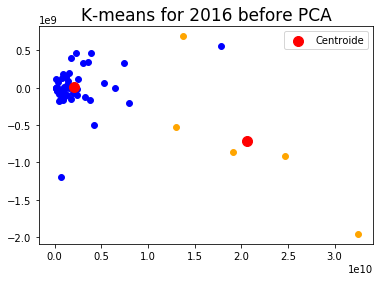

In [536]:
#k = 2
kmeans = KMeans(n_clusters = 2, init = 'k-means++', max_iter = 500, 
                n_init = 10, random_state = 0)
y_kmeans2016 = kmeans.fit_predict(x2016)

plt.scatter(x2016[y_kmeans2016 == 0, 0], x2016[y_kmeans2016 == 0, 1], s = 35, 
            c = 'orange')
plt.scatter(x2016[y_kmeans2016 == 1, 0], x2016[y_kmeans2016 == 1, 1], s = 35, 
            c = 'blue')

#Plotting the centroids of the clusters
plt.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:,1], s = 100, 
            c = 'red', label = 'Centroide')
plt.title('K-means for 2016 before PCA',fontsize=17)
plt.legend()

## K-means after PCA

### K-means for 2012 after PCA

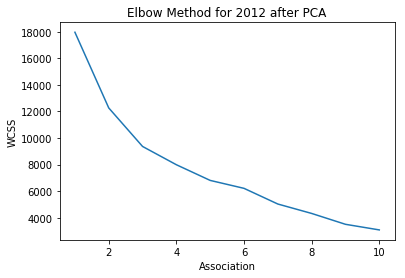

In [537]:
xx2012 = pca2012.iloc[:,0:20].values
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                    max_iter = 400, n_init = 10, random_state = 0)
    kmeans.fit(xx2012)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for 2012 after PCA')
plt.xlabel('Association')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

Text(0.5, 1.0, 'K-means for 2012 after PCA')

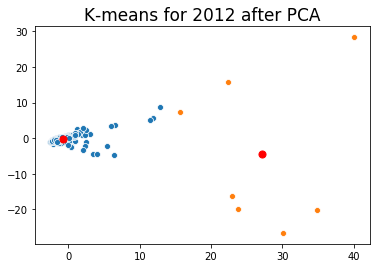

In [538]:
kmeans = KMeans(n_clusters = 2, init = 'k-means++', max_iter = 500, 
                n_init = 10, random_state = 0)
y_kmeans12 = kmeans.fit_predict(xx2012)

for i in range(0,2):
    sns.scatterplot(xx2012[y_kmeans12 == i, 0], xx2012[y_kmeans12 == i, 1])
plt.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:,1], s = 50, 
            c = 'red')
plt.title('K-means for 2012 after PCA',fontsize=17)

### K-means for 2013 after PCA

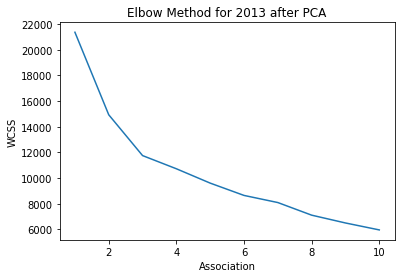

In [539]:
xx2013 = pca2013.iloc[:,0:20].values
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                    max_iter = 400, n_init = 10, random_state = 0)
    kmeans.fit(xx2013)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for 2013 after PCA')
plt.xlabel('Association')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

Text(0.5, 1.0, 'K-means for 2013 after PCA')

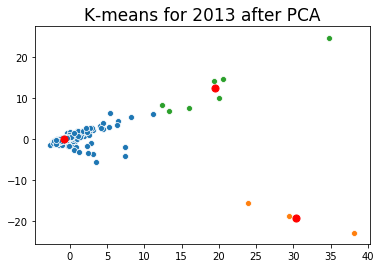

In [540]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 500, 
                n_init = 10, random_state = 0)
y_kmeans13 = kmeans.fit_predict(xx2013)

for i in range(0,3):
    sns.scatterplot(xx2013[y_kmeans13 == i, 0], xx2013[y_kmeans13 == i, 1])
plt.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:,1], s = 50, 
            c = 'red')
plt.title('K-means for 2013 after PCA',fontsize=17)

### K-means for 2014 after PCA

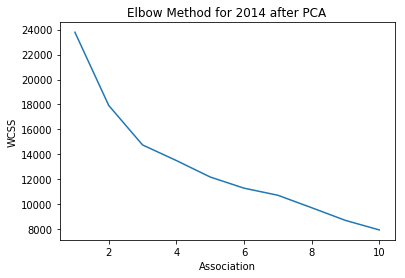

In [541]:
xx2014 = pca2014.iloc[:,0:20].values
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                    max_iter = 400, n_init = 10, random_state = 0)
    kmeans.fit(xx2014)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for 2014 after PCA')
plt.xlabel('Association')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

Text(0.5, 1.0, 'K-means for 2014 after PCA')

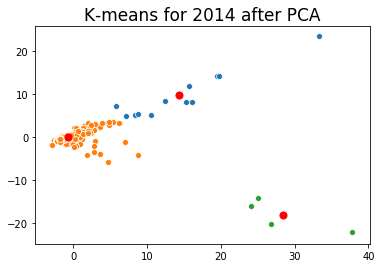

In [542]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 500, 
                n_init = 10, random_state = 0)
y_kmeans14 = kmeans.fit_predict(xx2014)

for i in range(0,3):
    sns.scatterplot(xx2014[y_kmeans14 == i, 0], xx2014[y_kmeans14 == i, 1])
plt.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:,1], s = 50, 
            c = 'red')
plt.title('K-means for 2014 after PCA',fontsize=17)

### K-means for 2015 after PCA

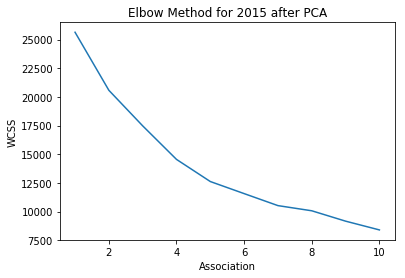

In [543]:
xx2015 = pca2015.iloc[:,0:20].values
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                    max_iter = 400, n_init = 10, random_state = 0)
    kmeans.fit(xx2015)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for 2015 after PCA')
plt.xlabel('Association')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

Text(0.5, 1.0, 'K-means for 2015 after PCA')

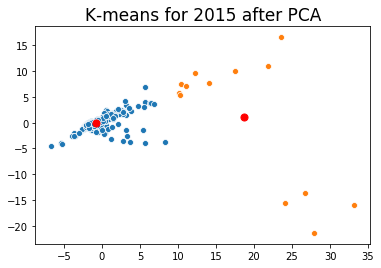

In [544]:
kmeans = KMeans(n_clusters = 2, init = 'k-means++', max_iter = 500, 
                n_init = 10, random_state = 0)
y_kmeans15 = kmeans.fit_predict(xx2015)

for i in range(0,2):
    sns.scatterplot(xx2015[y_kmeans15 == i, 0], xx2015[y_kmeans15 == i, 1])
plt.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:,1], s = 50, 
            c = 'red')
plt.title('K-means for 2015 after PCA',fontsize=17)

### K-means for 2016 after PCA

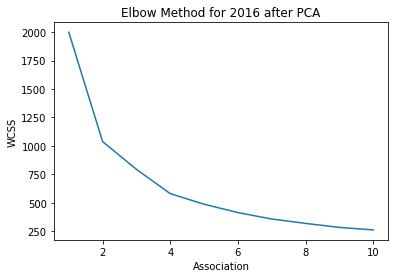

In [545]:
xx2016 = pca2016.iloc[:,0:20].values
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                    max_iter = 400, n_init = 10, random_state = 0)
    kmeans.fit(xx2016)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for 2016 after PCA')
plt.xlabel('Association')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

Text(0.5, 1.0, 'K-means for 2016 after PCA')

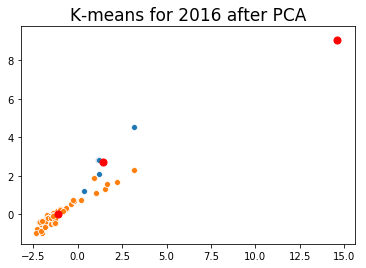

In [546]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 500, 
                n_init = 10, random_state = 0)
y_kmeans16 = kmeans.fit_predict(xx2016)

for i in range(0,3):
    sns.scatterplot(xx2016[y_kmeans16 == i, 0], xx2016[y_kmeans16 == i, 1])
plt.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:,1], s = 50, 
            c = 'red')
plt.title('K-means for 2016 after PCA',fontsize=17)

## DBSCAN before PCA

### DBSCAN for 2012 before PCA

Text(0.5, 1.0, 'DBSCAN for 2012 before PCA')

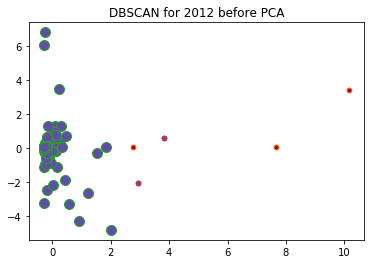

In [547]:
from sklearn.preprocessing import StandardScaler

bp2012 = data2012.iloc[:,0:82].values
stscaler = StandardScaler().fit(bp2012)
st2012 = stscaler.transform(bp2012)

from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = 30.7, min_samples = 5).fit(st2012)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0,1, len(unique_labels)))
for (label, color) in zip(unique_labels, colors):
    class_member_mask = (labels == label)
    xy = st2012[class_member_mask & core_samples]
    plt.plot(xy[:,0],xy[:,1], 'o', markerfacecolor = color, markersize = 10)
    
    xy2 = st2012[class_member_mask & ~core_samples]
    plt.plot(xy2[:,0],xy2[:,1], 'o', markerfacecolor = color, markersize = 5)
plt.title("DBSCAN for 2012 before PCA")

### DBSCAN for 2013 before PCA

Text(0.5, 1.0, 'DBSCAN for 2013 before PCA')

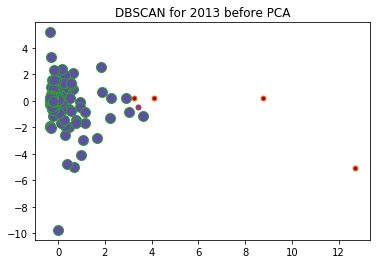

In [548]:
from sklearn.preprocessing import StandardScaler

bp2013 = data2013.iloc[:,0:82].values
stscaler = StandardScaler().fit(bp2013)
st2013 = stscaler.transform(bp2013)

from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = 30.7, min_samples = 5).fit(st2013)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0,1, len(unique_labels)))
for (label, color) in zip(unique_labels, colors):
    class_member_mask = (labels == label)
    xy = st2013[class_member_mask & core_samples]
    plt.plot(xy[:,0],xy[:,1], 'o', markerfacecolor = color, markersize = 10)
    
    xy2 = st2013[class_member_mask & ~core_samples]
    plt.plot(xy2[:,0],xy2[:,1], 'o', markerfacecolor = color, markersize = 5)
plt.title("DBSCAN for 2013 before PCA")

### DBSCAN for 2014 before PCA

Text(0.5, 1.0, 'DBSCAN for 2014 before PCA')

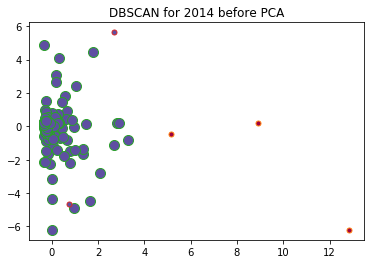

In [549]:
from sklearn.preprocessing import StandardScaler

bp2014 = data2014.iloc[:,0:82].values
stscaler = StandardScaler().fit(bp2014)
st2014 = stscaler.transform(bp2014)

from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = 30.7, min_samples = 5).fit(st2014)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0,1, len(unique_labels)))
for (label, color) in zip(unique_labels, colors):
    class_member_mask = (labels == label)
    xy = st2014[class_member_mask & core_samples]
    plt.plot(xy[:,0],xy[:,1], 'o', markerfacecolor = color, markersize = 10)
    
    xy2 = st2014[class_member_mask & ~core_samples]
    plt.plot(xy2[:,0],xy2[:,1], 'o', markerfacecolor = color, markersize = 5)
plt.title("DBSCAN for 2014 before PCA")

### DBSCAN for 2015 before PCA

Text(0.5, 1.0, 'DBSCAN for 2015 before PCA')

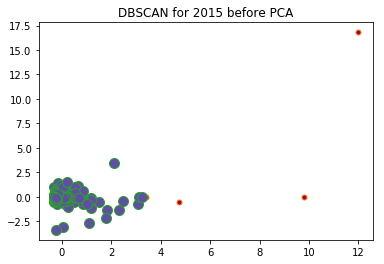

In [550]:
from sklearn.preprocessing import StandardScaler

bp2015 = data2015.iloc[:,0:82].values
stscaler = StandardScaler().fit(bp2015)
st2015 = stscaler.transform(bp2015)

from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = 30.7, min_samples = 5).fit(st2015)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0,1, len(unique_labels)))
for (label, color) in zip(unique_labels, colors):
    class_member_mask = (labels == label)
    xy = st2015[class_member_mask & core_samples]
    plt.plot(xy[:,0],xy[:,1], 'o', markerfacecolor = color, markersize = 10)
    
    xy2 = st2015[class_member_mask & ~core_samples]
    plt.plot(xy2[:,0],xy2[:,1], 'o', markerfacecolor = color, markersize = 5)
plt.title("DBSCAN for 2015 before PCA")

### DBSCAN for 2016 before PCA

Text(0.5, 1.0, 'DBSCAN for 2016 before PCA')

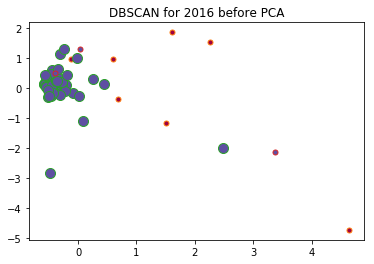

In [551]:
from sklearn.preprocessing import StandardScaler

bp2016 = data2016.iloc[:,0:82].values
stscaler = StandardScaler().fit(bp2016)
st2016 = stscaler.transform(bp2016)

from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = 10.7, min_samples = 20).fit(st2016)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0,1, len(unique_labels)))
for (label, color) in zip(unique_labels, colors):
    class_member_mask = (labels == label)
    xy = st2016[class_member_mask & core_samples]
    plt.plot(xy[:,0],xy[:,1], 'o', markerfacecolor = color, markersize = 10)
    
    xy2 = st2016[class_member_mask & ~core_samples]
    plt.plot(xy2[:,0],xy2[:,1], 'o', markerfacecolor = color, markersize = 5)
plt.title("DBSCAN for 2016 before PCA")

## DBSCAN after PCA

### DBSCAN for 2012 after PCA

Text(0.5, 1.0, 'DBSCAN for 2012 after PCA')

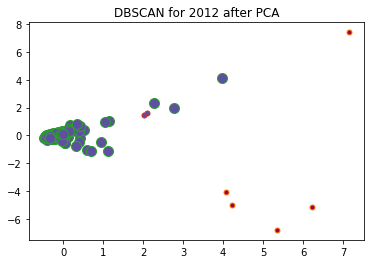

In [552]:
ap2012 = pca2012.iloc[:,0:20].values
stscaler = StandardScaler().fit(ap2012)
stp2012 = stscaler.transform(ap2012)

from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = 10.7, min_samples = 20).fit(stp2012)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0,1, len(unique_labels)))
for (label, color) in zip(unique_labels, colors):
    class_member_mask = (labels == label)
    xy = stp2012[class_member_mask & core_samples]
    plt.plot(xy[:,0],xy[:,1], 'o', markerfacecolor = color, markersize = 10)
    
    xy2 = stp2012[class_member_mask & ~core_samples]
    plt.plot(xy2[:,0],xy2[:,1], 'o', markerfacecolor = color, markersize = 5)
plt.title("DBSCAN for 2012 after PCA")

### DBSCAN for 2013 after PCA

Text(0.5, 1.0, 'DBSCAN for 2013 after PCA')

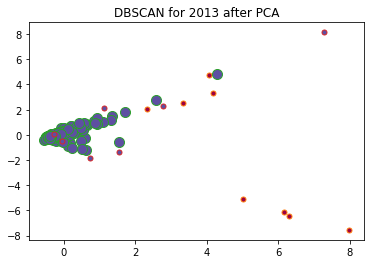

In [553]:
ap2013 = pca2013.iloc[:,0:20].values
stscaler = StandardScaler().fit(ap2013)
stp2013 = stscaler.transform(ap2013)

from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = 10.7, min_samples = 20).fit(stp2013)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0,1, len(unique_labels)))
for (label, color) in zip(unique_labels, colors):
    class_member_mask = (labels == label)
    xy = stp2013[class_member_mask & core_samples]
    plt.plot(xy[:,0],xy[:,1], 'o', markerfacecolor = color, markersize = 10)
    
    xy2 = stp2013[class_member_mask & ~core_samples]
    plt.plot(xy2[:,0],xy2[:,1], 'o', markerfacecolor = color, markersize = 5)
plt.title("DBSCAN for 2013 after PCA")

### DBSCAN for 2014 after PCA

Text(0.5, 1.0, 'DBSCAN for 2014 after PCA')

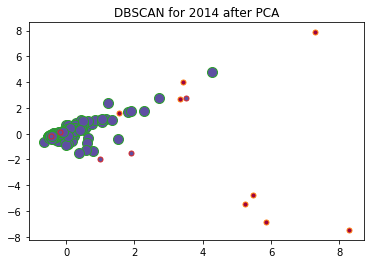

In [554]:
ap2014 = pca2014.iloc[:,0:20].values
stscaler = StandardScaler().fit(ap2014)
stp2014 = stscaler.transform(ap2014)

from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = 10.7, min_samples = 20).fit(stp2014)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0,1, len(unique_labels)))
for (label, color) in zip(unique_labels, colors):
    class_member_mask = (labels == label)
    xy = stp2014[class_member_mask & core_samples]
    plt.plot(xy[:,0],xy[:,1], 'o', markerfacecolor = color, markersize = 10)
    
    xy2 = stp2014[class_member_mask & ~core_samples]
    plt.plot(xy2[:,0],xy2[:,1], 'o', markerfacecolor = color, markersize = 5)
plt.title("DBSCAN for 2014 after PCA")

### DBSCAN for 2015 after PCA

Text(0.5, 1.0, 'DBSCAN for 2015 after PCA')

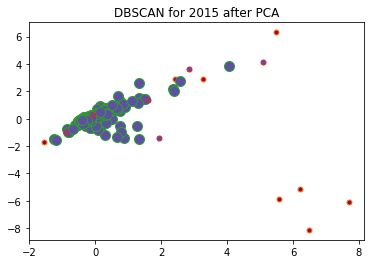

In [555]:
ap2015 = pca2015.iloc[:,0:20].values
stscaler = StandardScaler().fit(ap2015)
stp2015 = stscaler.transform(ap2015)

from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = 10.7, min_samples = 20).fit(stp2015)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0,1, len(unique_labels)))
for (label, color) in zip(unique_labels, colors):
    class_member_mask = (labels == label)
    xy = stp2015[class_member_mask & core_samples]
    plt.plot(xy[:,0],xy[:,1], 'o', markerfacecolor = color, markersize = 10)
    
    xy2 = stp2015[class_member_mask & ~core_samples]
    plt.plot(xy2[:,0],xy2[:,1], 'o', markerfacecolor = color, markersize = 5)
plt.title("DBSCAN for 2015 after PCA")

### DBSCAN for 2016 after PCA

Text(0.5, 1.0, 'DBSCAN for 2016 after PCA')

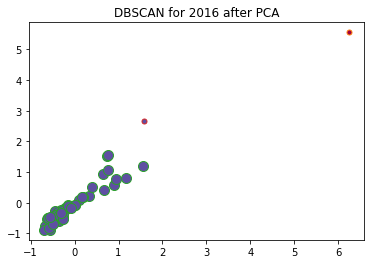

In [556]:
ap2016 = pca2016.iloc[:,0:20].values
stscaler = StandardScaler().fit(ap2016)
stp2016 = stscaler.transform(ap2016)

from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = 10.7, min_samples = 20).fit(stp2016)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0,1, len(unique_labels)))
for (label, color) in zip(unique_labels, colors):
    class_member_mask = (labels == label)
    xy = stp2016[class_member_mask & core_samples]
    plt.plot(xy[:,0],xy[:,1], 'o', markerfacecolor = color, markersize = 10)
    
    xy2 = stp2016[class_member_mask & ~core_samples]
    plt.plot(xy2[:,0],xy2[:,1], 'o', markerfacecolor = color, markersize = 5)
plt.title("DBSCAN for 2016 after PCA")

## Hierarchical Clustering before PCA

### HC for 2012 before PCA

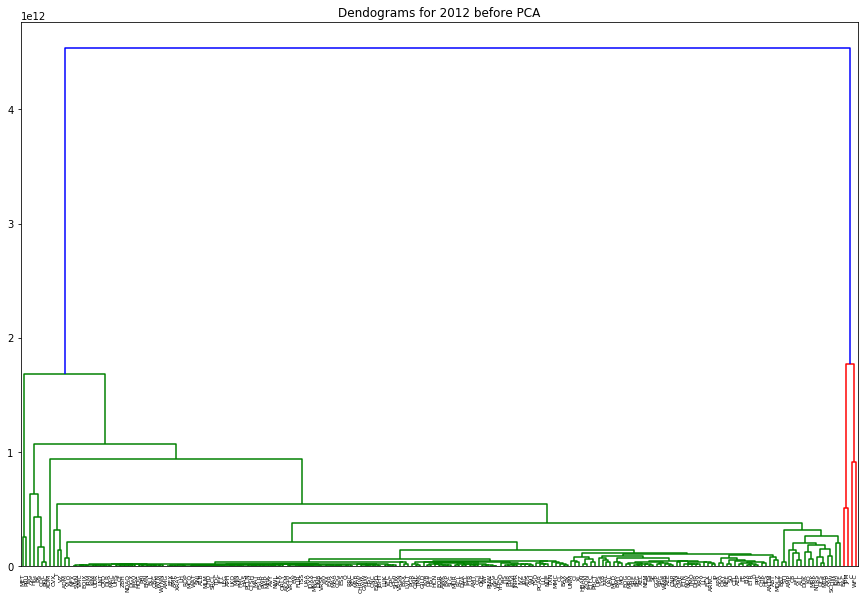

['AAL', 'ABT', 'ADM', 'ADS', 'AEE', 'AEP', 'AFL', 'AIG', 'AIV', 'AKAM', 'ALB', 'ALK', 'ALL', 'AME', 'AMG', 'AMP', 'AMT', 'ANTM', 'AON', 'APA', 'APH', 'ARNC', 'ATVI', 'AVB', 'AVY', 'AWK', 'AXP', 'BAC', 'BAX', 'BBT', 'BK', 'BLL', 'BMY', 'BSX', 'BXP', 'C', 'CB', 'CBG', 'CCI', 'CF', 'CHD', 'CHK', 'CHRW', 'CI', 'CINF', 'CL', 'CME', 'CNC', 'CNP', 'COF', 'COG', 'CTL', 'CTSH', 'CVX', 'CXO', 'D', 'DFS', 'DGX', 'DHR', 'DLR', 'DNB', 'DUK', 'DVA', 'ECL', 'EFX', 'EIX', 'EMN', 'EOG', 'EQIX', 'EQR', 'ES', 'ESS', 'ETFC', 'ETN', 'ETR', 'EW', 'EXPD', 'EXR', 'FCX', 'FE', 'FIS', 'FISV', 'FLIR', 'FMC', 'FSLR', 'FTR', 'GGP', 'GILD', 'GPC', 'GWW', 'HAS', 'HBAN', 'HCN', 'HES', 'HIG', 'HOG', 'HST', 'HSY', 'IBM', 'IDXX', 'IFF', 'IP', 'IPG', 'IRM', 'IVZ', 'JBHT', 'JNPR', 'JPM', 'KIM', 'KO', 'LEG', 'LH', 'LKQ', 'LLL', 'LLY', 'LNT', 'LUK', 'LVLT', 'LYB', 'MAA', 'MAC', 'MAR', 'MAT', 'MCD', 'MCO', 'MDLZ', 'MET', 'MHK', 'MJN', 'MLM', 'MMC', 'MNST', 'MO', 'MRK', 'MRO', 'MTB', 'MUR', 'NDAQ', 'NEE', 'NEM', 'NFX', 'NOV',

In [557]:
import matplotlib.pyplot as plt  
%matplotlib inline
hcbp12 = data2012.iloc[:,0:82].values

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
plt.figure(figsize=(15, 10))  
plt.title("Dendograms for 2012 before PCA")
mergings = linkage(hcbp12, method='complete')#ward)
labels=names2012
#labels = fcluster(mergings, 70, criterion='distance')
dendrogram(mergings,
           labels=names2012,
           leaf_rotation=90,
           leaf_font_size=6)

plt.show()

print(labels)

In [558]:
from sklearn.cluster import AgglomerativeClustering


cluster = AgglomerativeClustering(n_clusters=12, affinity='euclidean', 
                                  linkage='ward')  
cluster.fit_predict(hcbp12) 

array([ 1,  1,  1, 10, 10,  1,  3,  9, 10, 10, 10, 10,  3, 10, 10,  3, 10,
        1,  1,  1, 10,  1, 10, 10, 10, 10,  3, 11, 10,  3,  0, 10,  1, 10,
       10,  6,  1, 10, 10, 10, 10,  1, 10,  1, 10, 10,  1, 10, 10,  0, 10,
        1, 10,  2, 10,  1,  3, 10,  1, 10, 10,  1, 10, 10, 10,  1, 10,  1,
       10, 10,  1, 10,  1,  1,  1, 10, 10, 10,  1,  1, 10, 10, 10, 10, 10,
       10,  1, 10, 10, 10, 10,  1, 10,  1,  0, 10, 10, 10,  2, 10, 10,  1,
       10, 10, 10, 10, 10,  8, 10,  1, 10, 10, 10, 10,  1, 10, 10, 10, 10,
       10, 10, 10, 10,  1, 10,  1,  4, 10, 10, 10, 10, 10,  1,  1,  1,  3,
       10, 10,  1,  1, 10,  1,  3, 10, 10, 10, 10, 10,  1,  1, 10, 10, 10,
        1,  2, 10,  0, 10, 10,  1,  4, 10, 10, 10, 10, 10, 10,  3,  1, 10,
       10, 10,  1,  1, 10,  1,  3, 10,  2, 10, 10,  1, 10, 10, 10, 10,  1,
       10, 10,  1,  1, 10,  1, 10, 10, 10, 10,  2, 10, 10,  7,  1, 10, 10,
       10, 10, 10,  1,  1,  5, 10,  1, 10, 10,  1])

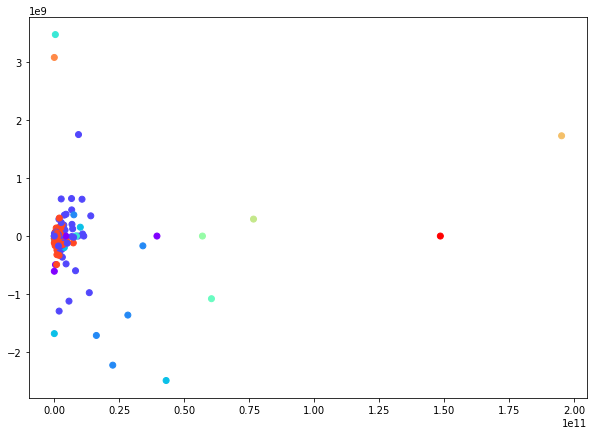

In [559]:
plt.figure(figsize=(10, 7))  
plt.scatter(hcbp12[:,0], hcbp12[:,1], c=cluster.labels_, cmap='rainbow')  

### HC for 2013 before PCA

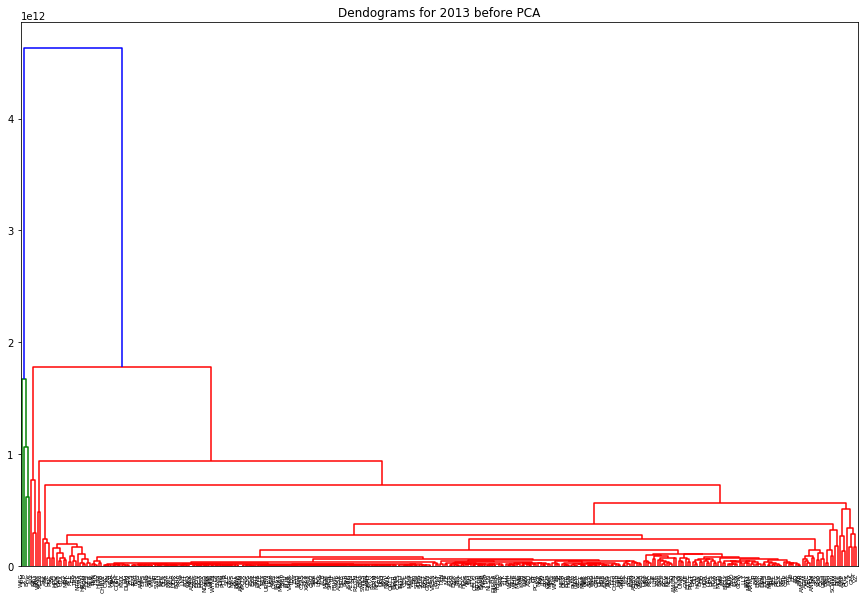

['AAL', 'ABBV', 'ABC', 'ABT', 'ADBE', 'ADM', 'ADS', 'ADSK', 'AEE', 'AEP', 'AFL', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALK', 'ALL', 'ALLE', 'ALXN', 'AME', 'AMG', 'AMGN', 'AMP', 'AMT', 'AMZN', 'AN', 'ANTM', 'AON', 'APA', 'APC', 'APD', 'APH', 'ARNC', 'ATVI', 'AVB', 'AWK', 'AXP', 'BA', 'BAC', 'BAX', 'BBT', 'BCR', 'BDX', 'BHI', 'BIIB', 'BK', 'BLL', 'BMY', 'BSX', 'BWA', 'BXP', 'C', 'CAT', 'CB', 'CBG', 'CCI', 'CELG', 'CF', 'CHD', 'CHK', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CMA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COG', 'COL', 'COO', 'CRM', 'CSX', 'CTAS', 'CTL', 'CTSH', 'CTXS', 'CVS', 'CVX', 'CXO', 'D', 'DAL', 'DD', 'DE', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DISCA', 'DISCK', 'DLPH', 'DLR', 'DNB', 'DOV', 'DPS', 'DUK', 'DVA', 'DVN', 'EBAY', 'ECL', 'ED', 'EFX', 'EIX', 'EMN', 'EMR', 'EOG', 'EQIX', 'EQR', 'EQT', 'ES', 'ESS', 'ETFC', 'ETN', 'ETR', 'EW', 'EXC', 'EXPD', 'EXPE', 'EXR', 'F', 'FAST', 'FB', 'FBHS', 'FCX', 'FDX', 'FE', 'FFIV', 'FIS', 'FISV', 'FLIR', 'FLR', 'FLS', 'FMC',

In [560]:
import matplotlib.pyplot as plt  
%matplotlib inline
hcbp13 = data2013.iloc[:,0:82].values

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
plt.figure(figsize=(15, 10))  
plt.title("Dendograms for 2013 before PCA")
mergings = linkage(hcbp13, method='complete')#ward)
labels=names2013
#labels = fcluster(mergings, 70, criterion='distance')
dendrogram(mergings,
           labels=names2013,
           leaf_rotation=90,
           leaf_font_size=6)

plt.show()

print(labels)

In [561]:
from sklearn.cluster import AgglomerativeClustering


cluster = AgglomerativeClustering(n_clusters=12, affinity='euclidean', 
                                  linkage='ward')  
cluster.fit_predict(hcbp13) 

array([11, 11,  3, 11,  8,  3,  8,  8,  8, 11,  1, 10,  8,  8,  8,  8,  8,
        8,  1,  8,  8,  8,  8, 11,  1,  8,  3,  8,  3, 11, 11, 11,  8,  8,
       11,  8,  8,  8,  1,  3,  0, 11,  1,  8,  8, 11,  8,  6,  8, 11,  8,
        8,  8,  0,  3,  1,  8,  8,  8,  8,  8, 11,  8,  8, 11,  8,  8,  1,
       11,  8,  8,  8,  8,  8,  6,  8,  8,  8,  8, 11,  8, 11,  8,  8,  3,
        4,  8, 11, 11, 11, 11,  1,  8,  8,  8, 11,  8,  8,  8,  8,  8,  8,
        8, 11,  8, 11, 11,  8, 11,  8, 11,  8, 11, 11,  8,  8,  8, 11,  8,
       11, 11, 11,  8, 11,  8,  8,  8,  4,  8,  8,  8, 11, 11, 11,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8, 11,  8,  8, 11,  4,  8,  8,  8,  8,
       11,  1, 11,  8,  8, 11,  1,  8, 11,  8,  3,  8,  8,  8,  8,  8,  3,
        8,  8,  8, 11,  8,  8,  8,  8,  8,  8,  8,  8,  7,  8,  8,  8, 11,
        8,  3,  8,  8,  8,  8,  8, 11, 11,  8, 11, 11,  8,  8,  8,  8,  8,
        8,  8,  8,  8, 11,  8, 11,  5,  8,  8,  8,  8, 11,  8, 11,  8,  3,
        3, 11,  1,  8,  8

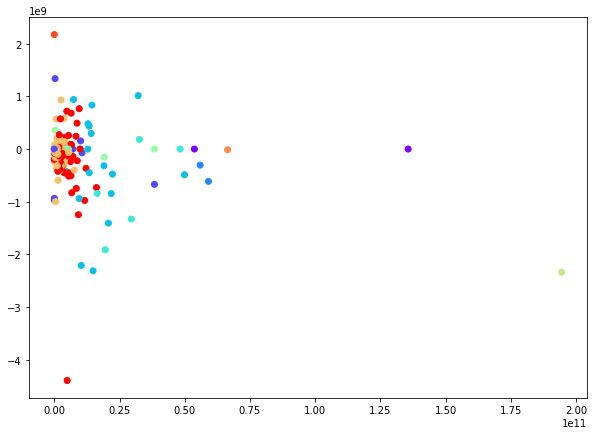

In [562]:
plt.figure(figsize=(10, 7))  
plt.scatter(hcbp13[:,0], hcbp13[:,1], c=cluster.labels_, cmap='rainbow') 

### HC for 2014 before PCA

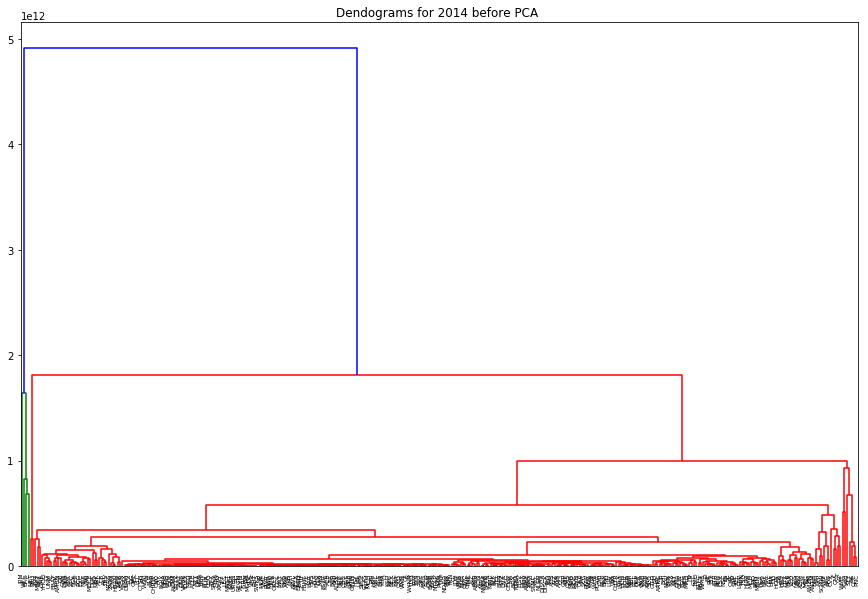

['AAL', 'ABBV', 'ABC', 'ABT', 'ADBE', 'ADM', 'ADS', 'ADSK', 'AEE', 'AEP', 'AFL', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALK', 'ALL', 'ALLE', 'ALXN', 'AME', 'AMG', 'AMGN', 'AMP', 'AMT', 'AMZN', 'AN', 'ANTM', 'AON', 'APA', 'APC', 'APD', 'APH', 'ARNC', 'ATVI', 'AVB', 'AWK', 'AXP', 'BA', 'BAC', 'BAX', 'BBT', 'BCR', 'BDX', 'BHI', 'BIIB', 'BK', 'BLL', 'BMY', 'BSX', 'BWA', 'BXP', 'C', 'CAH', 'CAT', 'CB', 'CBG', 'CCI', 'CELG', 'CF', 'CHD', 'CHK', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COG', 'COL', 'COO', 'CRM', 'CSX', 'CTL', 'CTSH', 'CTXS', 'CVS', 'CVX', 'CXO', 'D', 'DAL', 'DD', 'DE', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DISCA', 'DISCK', 'DLPH', 'DLR', 'DNB', 'DOV', 'DPS', 'DUK', 'DVA', 'DVN', 'EA', 'EBAY', 'ECL', 'ED', 'EFX', 'EIX', 'EL', 'EMN', 'EMR', 'EOG', 'EQIX', 'EQR', 'EQT', 'ES', 'ESS', 'ETFC', 'ETN', 'ETR', 'EW', 'EXC', 'EXPD', 'EXPE', 'EXR', 'F', 'FAST', 'FB', 'FBHS', 'FCX', 'FE', 'FFIV', 'FIS', 'FISV', 'FLIR', 'FLR', 'F

In [563]:
import matplotlib.pyplot as plt  
%matplotlib inline
hcbp14 = data2014.iloc[:,0:82].values

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
plt.figure(figsize=(15, 10))  
plt.title("Dendograms for 2014 before PCA ")
mergings = linkage(hcbp14, method='complete')#ward)
labels=names2014
#labels = fcluster(mergings, 70, criterion='distance')
dendrogram(mergings,
           labels=names2014,
           leaf_rotation=90,
           leaf_font_size=6)

plt.show()

print(labels)

In [564]:
from sklearn.cluster import AgglomerativeClustering


cluster = AgglomerativeClustering(n_clusters=12, affinity='euclidean', 
                                  linkage='ward')  
cluster.fit_predict(hcbp14) 

array([ 0,  0,  0,  0,  5,  0,  5,  5,  5,  0,  4, 10,  5,  5,  5,  5,  5,
        5,  4,  5,  5,  5,  5,  0,  4,  5,  0,  5,  0,  0,  0,  0,  5,  5,
        0,  5,  5,  5,  4,  0, 11,  5,  4,  5,  5,  0,  5,  7,  5,  0,  5,
        5,  5,  6,  0,  0,  4,  5,  5,  5,  5,  5,  0,  5,  5,  0,  5,  5,
        5,  4,  0,  5,  5,  5,  5,  5,  7,  5,  5,  5,  5,  0,  0,  5,  5,
        0,  2,  5,  0,  0,  0,  0,  4,  5,  5,  5,  0,  5,  5,  5,  5,  5,
        5,  5,  0,  5,  0,  5,  0,  5,  0,  5,  0,  5,  5,  5,  0,  5,  5,
        5,  5,  5,  0,  0,  0,  5,  0,  5,  5,  5,  2,  5,  0,  5,  0,  0,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  0,  5,  0,  5,  2,  5,  5,
        5,  0,  5,  4,  0,  5,  5,  0,  2,  5,  0,  5,  0,  5,  5,  5,  5,
        0,  0,  5,  5,  5,  0,  5,  5,  5,  5,  5,  5,  5,  5,  9,  5,  5,
        5,  5,  0,  5,  0,  5,  5,  5,  5,  5,  0,  0,  5,  0,  0,  5,  5,
        0,  5,  5,  5,  5,  5,  5,  0,  5,  0,  5,  0,  3,  5,  5,  5,  5,
        0,  5,  0,  5,  0

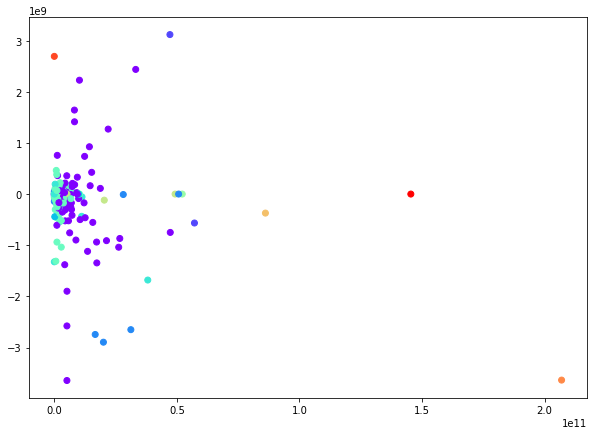

In [565]:
plt.figure(figsize=(10, 7))  
plt.scatter(hcbp14[:,0], hcbp14[:,1], c=cluster.labels_, cmap='rainbow') 

### HC for 2015 before PCA

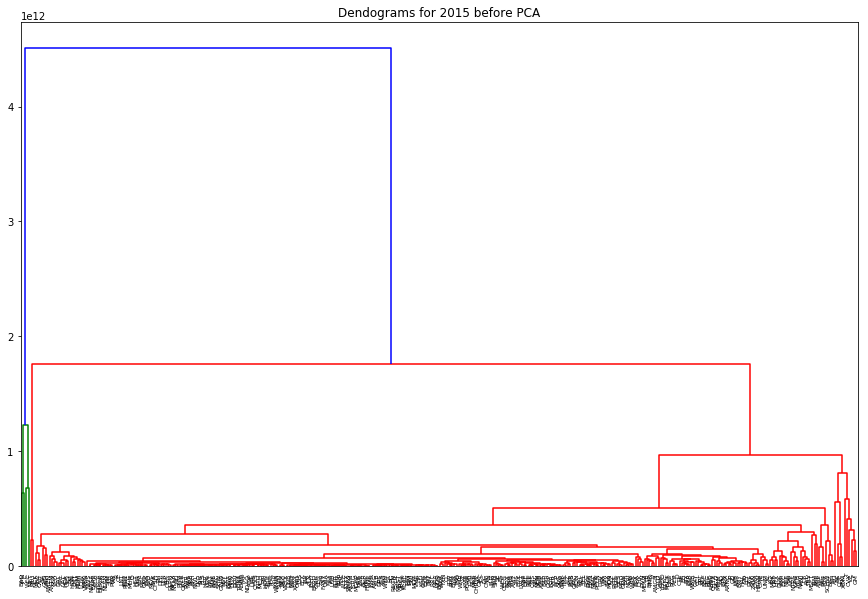

['AAL', 'ABBV', 'ABC', 'ABT', 'ADBE', 'ADM', 'ADS', 'AEE', 'AEP', 'AFL', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALK', 'ALL', 'ALLE', 'ALXN', 'AME', 'AMG', 'AMGN', 'AMP', 'AMT', 'AMZN', 'AN', 'ANTM', 'AON', 'APA', 'APC', 'APD', 'APH', 'ARNC', 'ATVI', 'AVB', 'AWK', 'AXP', 'AYI', 'BA', 'BAC', 'BAX', 'BBT', 'BCR', 'BDX', 'BHI', 'BIIB', 'BK', 'BLL', 'BMY', 'BSX', 'BWA', 'BXP', 'C', 'CAH', 'CAT', 'CB', 'CBG', 'CCI', 'CCL', 'CELG', 'CF', 'CFG', 'CHD', 'CHK', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COG', 'COL', 'CTL', 'CTSH', 'CTXS', 'CVS', 'CVX', 'CXO', 'D', 'DAL', 'DD', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DISCA', 'DISCK', 'DLPH', 'DLR', 'DNB', 'DOV', 'DPS', 'DUK', 'DVA', 'DVN', 'EA', 'EBAY', 'ECL', 'ED', 'EFX', 'EIX', 'EL', 'EMN', 'EMR', 'EOG', 'EQIX', 'EQR', 'EQT', 'ES', 'ESS', 'ETFC', 'ETN', 'ETR', 'EW', 'EXC', 'EXPD', 'EXPE', 'EXR', 'F', 'FAST', 'FB', 'FBHS', 'FCX', 'FE', 'FFIV', 'FIS', 'FISV', 'FLIR', 'FLR', 'FLS', 'FMC', 'F

In [572]:
import matplotlib.pyplot as plt  
%matplotlib inline
hcbp15 = data2015.iloc[:,0:82].values

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
plt.figure(figsize=(15, 10))  
plt.title("Dendograms for 2015 before PCA")
mergings = linkage(hcbp15, method='complete')#ward)
labels=names2015
#labels = fcluster(mergings, 70, criterion='distance')
dendrogram(mergings,
           labels=names2015,
           leaf_rotation=90,
           leaf_font_size=6)

plt.show()

print(labels)

In [573]:
from sklearn.cluster import AgglomerativeClustering


cluster = AgglomerativeClustering(n_clusters=12, affinity='euclidean', 
                                  linkage='ward')  
cluster.fit_predict(hcbp15) 

array([ 1,  1,  3,  1,  1,  3,  1,  1,  1,  0,  9,  1,  1,  1,  1,  1,  1,
        0,  1,  1,  1,  1,  1,  0,  1,  3,  1,  3,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  0,  1,  3, 11,  1,  0,  1,  1,  1,  1,  5,  1,  1,  1,
        1,  1,  8,  3,  3,  0,  1,  1,  1,  1,  1,  0,  1,  1,  1,  1,  1,
        1,  1,  1,  0,  1,  1,  1,  1,  1,  1,  5,  1,  1,  1,  1,  1,  3,
        2,  1,  1,  1,  1,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        3,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  3,  1,  1,  1,  2,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  1,  1,  1,  1,
        1,  0,  1,  1,  1,  1,  0,  1,  1,  1,  1,  1,  1,  3,  3,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  6,  1,  1,  1,  1,  3,  3,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  3,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  3,  1,  1,  7,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  3,  3,  1

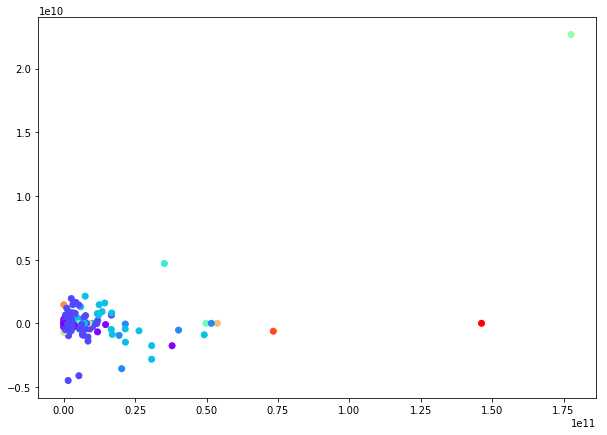

In [574]:
plt.figure(figsize=(10, 7))  
plt.scatter(hcbp15[:,0], hcbp15[:,1], c=cluster.labels_, cmap='rainbow') 

### HC for 2016 before PCA

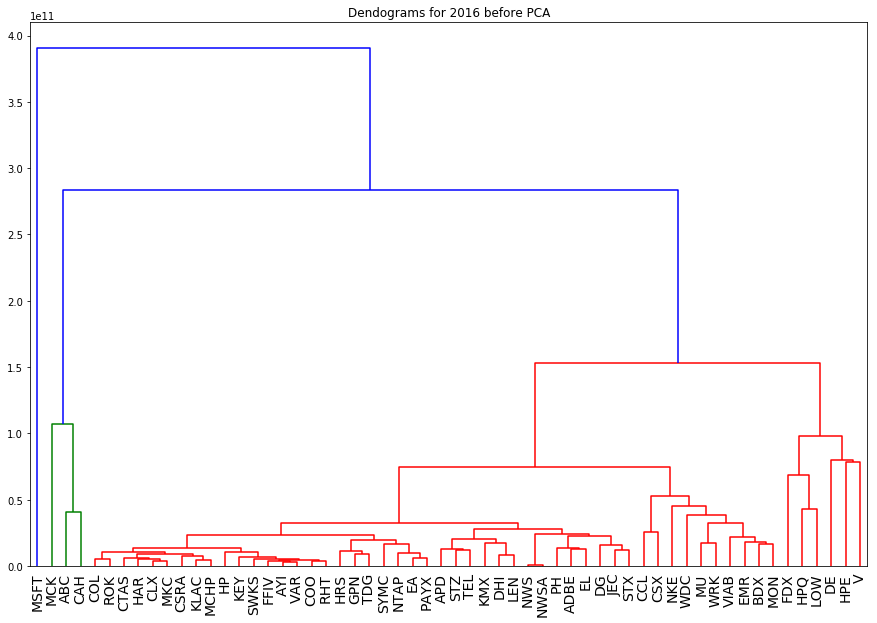

['ABC', 'ADBE', 'APD', 'AYI', 'BDX', 'CAH', 'CCL', 'CLX', 'COL', 'COO', 'CSRA', 'CSX', 'CTAS', 'DE', 'DG', 'DHI', 'EA', 'EL', 'EMR', 'FDX', 'FFIV', 'GPN', 'HAR', 'HP', 'HPE', 'HPQ', 'HRS', 'JEC', 'KEY', 'KLAC', 'KMX', 'LEN', 'LOW', 'MCHP', 'MCK', 'MKC', 'MON', 'MSFT', 'MU', 'NKE', 'NTAP', 'NWS', 'NWSA', 'PAYX', 'PH', 'RHT', 'ROK', 'STX', 'STZ', 'SWKS', 'SYMC', 'TDG', 'TEL', 'V', 'VAR', 'VIAB', 'WDC', 'WRK']


In [575]:
import matplotlib.pyplot as plt  
%matplotlib inline
hcbp16 = data2016.iloc[:,0:82].values

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
plt.figure(figsize=(15, 10))  
plt.title("Dendograms for 2016 before PCA")
mergings = linkage(hcbp16, method='complete')#ward)
labels=names2016
#labels = fcluster(mergings, 70, criterion='distance')
dendrogram(mergings,
           labels=names2016,
           leaf_rotation=90,
           leaf_font_size=14)

plt.show()

print(labels)

In [576]:
from sklearn.cluster import AgglomerativeClustering


cluster = AgglomerativeClustering(n_clusters=12, affinity='euclidean', 
                                  linkage='ward')  
cluster.fit_predict(hcbp16) 

array([ 1,  3,  3, 10,  0,  1,  4, 10, 10, 10, 10,  4, 10,  7,  3,  3, 10,
        3,  0, 11, 10,  3, 10, 10,  8,  2,  3,  3, 10, 10,  3,  3,  2, 10,
        6, 10,  0,  5,  0,  0, 10,  3,  3, 10,  3, 10, 10,  3,  3, 10,  3,
        3,  3,  9, 10,  0,  0,  0])

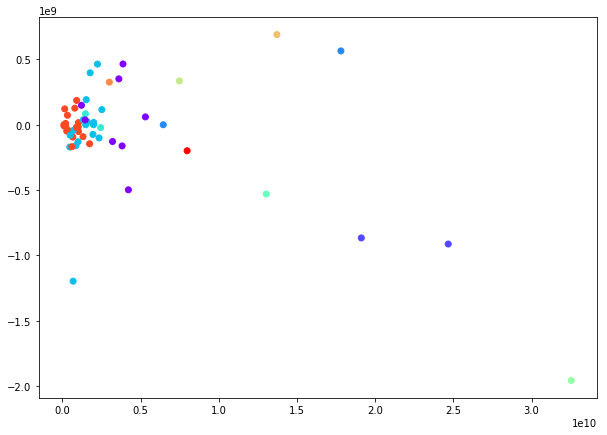

In [577]:
plt.figure(figsize=(10, 7))  
plt.scatter(hcbp16[:,0], hcbp16[:,1], c=cluster.labels_, cmap='rainbow')  

## Hierarchical Clustering after PCA

### HC for 2012 after PCA

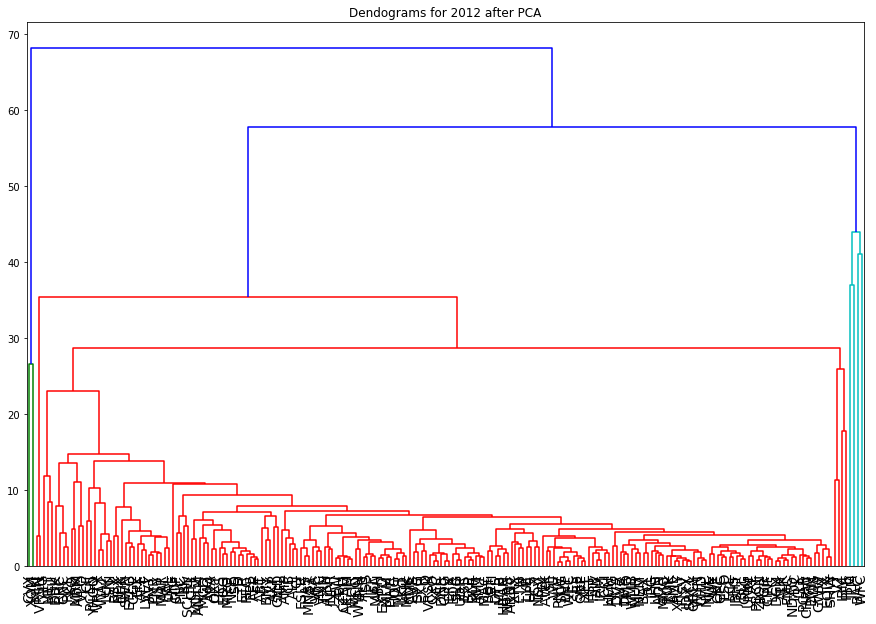

['AAL', 'ABT', 'ADM', 'ADS', 'AEE', 'AEP', 'AFL', 'AIG', 'AIV', 'AKAM', 'ALB', 'ALK', 'ALL', 'AME', 'AMG', 'AMP', 'AMT', 'ANTM', 'AON', 'APA', 'APH', 'ARNC', 'ATVI', 'AVB', 'AVY', 'AWK', 'AXP', 'BAC', 'BAX', 'BBT', 'BK', 'BLL', 'BMY', 'BSX', 'BXP', 'C', 'CB', 'CBG', 'CCI', 'CF', 'CHD', 'CHK', 'CHRW', 'CI', 'CINF', 'CL', 'CME', 'CNC', 'CNP', 'COF', 'COG', 'CTL', 'CTSH', 'CVX', 'CXO', 'D', 'DFS', 'DGX', 'DHR', 'DLR', 'DNB', 'DUK', 'DVA', 'ECL', 'EFX', 'EIX', 'EMN', 'EOG', 'EQIX', 'EQR', 'ES', 'ESS', 'ETFC', 'ETN', 'ETR', 'EW', 'EXPD', 'EXR', 'FCX', 'FE', 'FIS', 'FISV', 'FLIR', 'FMC', 'FSLR', 'FTR', 'GGP', 'GILD', 'GPC', 'GWW', 'HAS', 'HBAN', 'HCN', 'HES', 'HIG', 'HOG', 'HST', 'HSY', 'IBM', 'IDXX', 'IFF', 'IP', 'IPG', 'IRM', 'IVZ', 'JBHT', 'JNPR', 'JPM', 'KIM', 'KO', 'LEG', 'LH', 'LKQ', 'LLL', 'LLY', 'LNT', 'LUK', 'LVLT', 'LYB', 'MAA', 'MAC', 'MAR', 'MAT', 'MCD', 'MCO', 'MDLZ', 'MET', 'MHK', 'MJN', 'MLM', 'MMC', 'MNST', 'MO', 'MRK', 'MRO', 'MTB', 'MUR', 'NDAQ', 'NEE', 'NEM', 'NFX', 'NOV',

In [578]:
hcap12 = pca2012.iloc[:,0:20].values

plt.figure(figsize=(15, 10))  
plt.title("Dendograms for 2012 after PCA")
mergings = linkage(hcap12, method='complete')#ward)
labels=pcaname2012
#labels = fcluster(mergings, 70, criterion='distance')
dendrogram(mergings,
           labels=pcaname2012,
           leaf_rotation=90,
           leaf_font_size=14)

plt.show()

print(labels)

In [579]:
from sklearn.cluster import AgglomerativeClustering


cluster = AgglomerativeClustering(n_clusters=12, affinity='euclidean', 
                                  linkage='ward')  
cluster.fit_predict(hcap12) 

array([ 0,  5,  5,  0,  0,  0,  5,  6,  0,  0,  0,  0,  5,  0,  0,  5,  0,
        5,  0,  5,  0,  5,  0,  0,  0,  0,  5, 11,  0,  0,  5,  0,  5,  0,
        0,  8,  5,  0,  0,  0,  0,  0,  0,  5,  0,  0,  0,  0,  0,  5,  0,
        5,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  5,  0,  0,  0,  0,  5,  0,  0,  0,  0,  0,  0,
        0,  0,  5,  0,  0,  0,  0,  0,  0,  5,  0,  0,  0,  2,  0,  0,  5,
        0,  0,  0,  0,  0,  7,  0,  2,  0,  0,  0,  0,  5,  0,  0,  0,  5,
        0,  0,  0,  0,  5,  0,  5,  6,  0,  4,  0,  0,  0,  5,  2,  0,  0,
        0,  0,  0,  0,  0,  5,  0,  0,  0,  0,  0,  0,  5,  0,  0,  0,  0,
        0,  2,  0,  5,  0,  0,  0,  6,  0,  0,  0,  0,  0,  0,  5,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  5,  0,  5,  0,  0,  4,  0,  1,  0,  0,  3,  0,  0,  0,
        0,  0,  0,  0,  0,  9,  0,  5,  0,  0,  0])

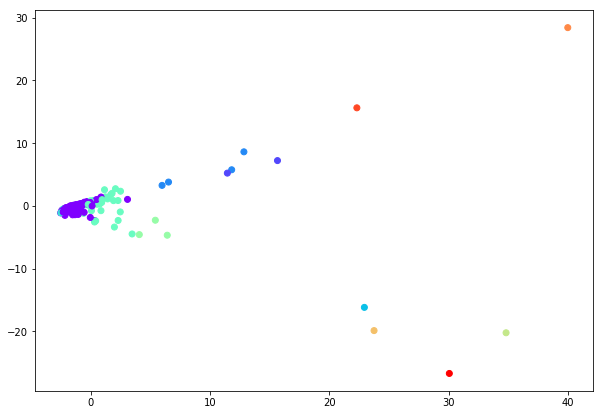

In [580]:
plt.figure(figsize=(10, 7))  
plt.scatter(hcap12[:,0], hcap12[:,1], c=cluster.labels_, cmap='rainbow')  

### HC for 2013 after PCA

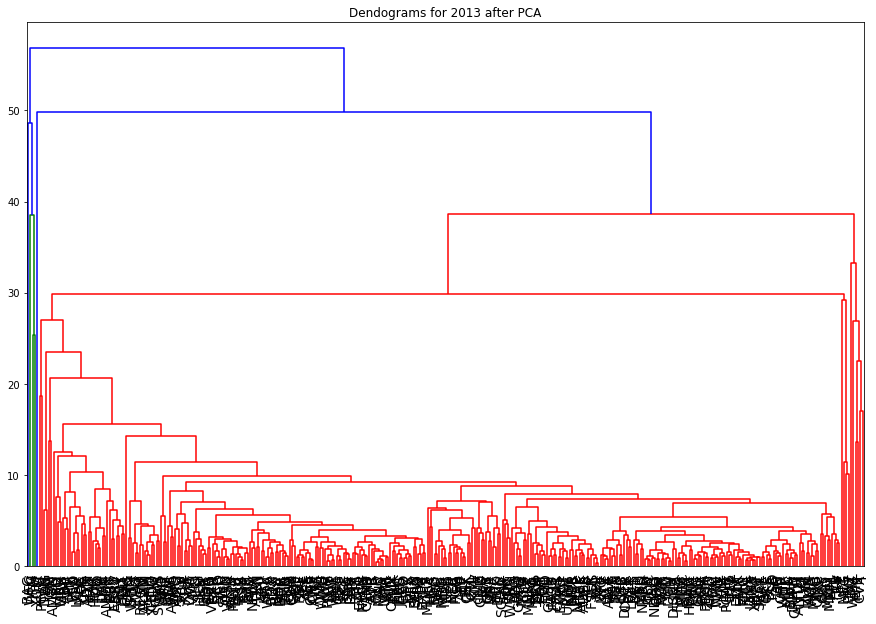

['AAL', 'ABBV', 'ABC', 'ABT', 'ADBE', 'ADM', 'ADS', 'ADSK', 'AEE', 'AEP', 'AFL', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALK', 'ALL', 'ALLE', 'ALXN', 'AME', 'AMG', 'AMGN', 'AMP', 'AMT', 'AMZN', 'AN', 'ANTM', 'AON', 'APA', 'APC', 'APD', 'APH', 'ARNC', 'ATVI', 'AVB', 'AWK', 'AXP', 'BA', 'BAC', 'BAX', 'BBT', 'BCR', 'BDX', 'BHI', 'BIIB', 'BK', 'BLL', 'BMY', 'BSX', 'BWA', 'BXP', 'C', 'CAT', 'CB', 'CBG', 'CCI', 'CELG', 'CF', 'CHD', 'CHK', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CMA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COG', 'COL', 'COO', 'CRM', 'CSX', 'CTAS', 'CTL', 'CTSH', 'CTXS', 'CVS', 'CVX', 'CXO', 'D', 'DAL', 'DD', 'DE', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DISCA', 'DISCK', 'DLPH', 'DLR', 'DNB', 'DOV', 'DPS', 'DUK', 'DVA', 'DVN', 'EBAY', 'ECL', 'ED', 'EFX', 'EIX', 'EMN', 'EMR', 'EOG', 'EQIX', 'EQR', 'EQT', 'ES', 'ESS', 'ETFC', 'ETN', 'ETR', 'EW', 'EXC', 'EXPD', 'EXPE', 'EXR', 'F', 'FAST', 'FB', 'FBHS', 'FCX', 'FDX', 'FE', 'FFIV', 'FIS', 'FISV', 'FLIR', 'FLR', 'FLS', 'FMC',

In [581]:
hcap13 = pca2013.iloc[:,0:20].values

plt.figure(figsize=(15, 10))  
plt.title("Dendograms for 2013 after PCA")
mergings = linkage(hcap13, method='complete')#ward)
labels=pcaname2013
#labels = fcluster(mergings, 70, criterion='distance')
dendrogram(mergings,
           labels=pcaname2013,
           leaf_rotation=90,
           leaf_font_size=14)

plt.show()

print(labels)

In [582]:
from sklearn.cluster import AgglomerativeClustering


cluster = AgglomerativeClustering(n_clusters=12, affinity='euclidean', 
                                  linkage='ward')  
cluster.fit_predict(hcap13) 

array([ 0,  0,  3,  0,  4,  0,  4,  4,  0,  0,  0,  9,  0,  0,  0,  4,  4,
        0,  0,  0,  4,  0,  0,  0,  0,  0,  3,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  3,  7,  0,  0,  4,  4,  0,  4,  0,  0,  0,  0,
        0,  0,  2,  0,  0,  0,  0,  4,  4,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  0,  4,  0,  3,
        1,  0,  0,  0,  0,  3,  0,  0,  0,  3,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  0,  0,
        0,  0,  0,  4,  0,  4,  0,  0, 10,  4,  4,  0,  0,  0,  0,  0,  0,
        0,  4,  0,  0,  0,  0,  4,  0,  0,  0,  0,  4,  3,  0,  0,  0,  4,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  3,  0,  0,  0,  0,  0,  1,
        0,  4,  0,  0,  0,  0,  4,  0,  0,  0,  0,  4,  2,  0,  0,  0,  0,
        0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  3,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  4,  0,  4,  0,  9,  0,  0,  4,  0,  0,  0,  0,  4,  3,
        3,  0,  0,  4,  0

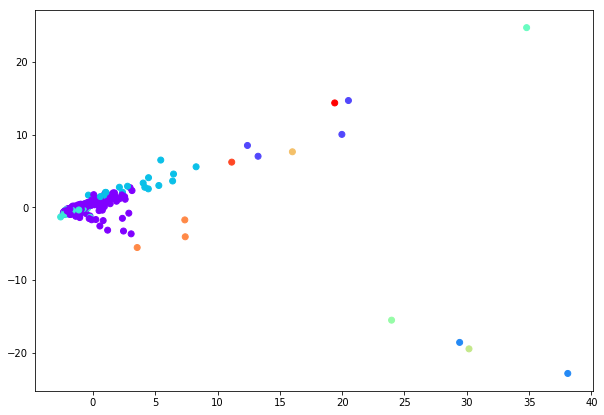

In [583]:
plt.figure(figsize=(10, 7))  
plt.scatter(hcap13[:,0], hcap13[:,1], c=cluster.labels_, cmap='rainbow')  

### HC for 2014 after PCA

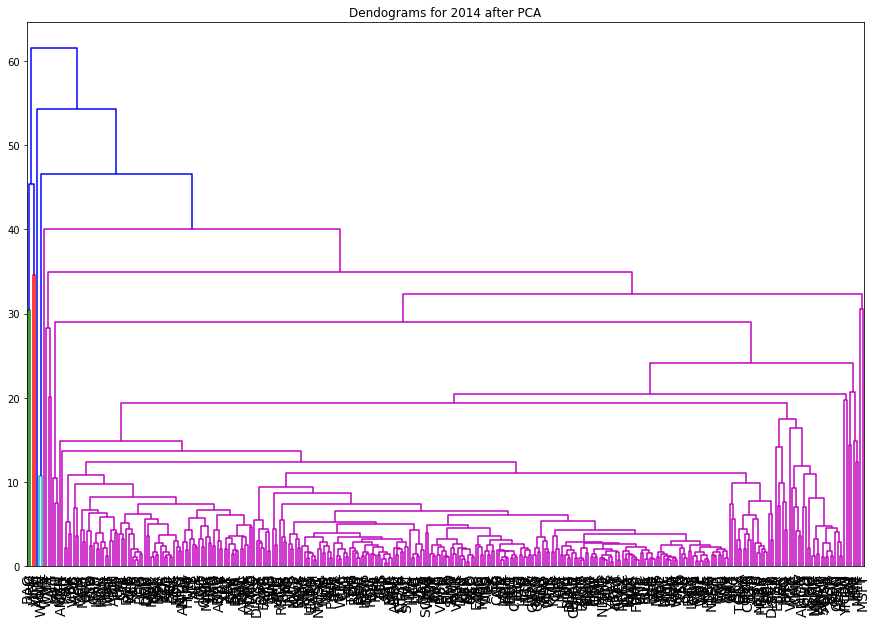

['AAL', 'ABBV', 'ABC', 'ABT', 'ADBE', 'ADM', 'ADS', 'ADSK', 'AEE', 'AEP', 'AFL', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALK', 'ALL', 'ALLE', 'ALXN', 'AME', 'AMG', 'AMGN', 'AMP', 'AMT', 'AMZN', 'AN', 'ANTM', 'AON', 'APA', 'APC', 'APD', 'APH', 'ARNC', 'ATVI', 'AVB', 'AWK', 'AXP', 'BA', 'BAC', 'BAX', 'BBT', 'BCR', 'BDX', 'BHI', 'BIIB', 'BK', 'BLL', 'BMY', 'BSX', 'BWA', 'BXP', 'C', 'CAH', 'CAT', 'CB', 'CBG', 'CCI', 'CELG', 'CF', 'CHD', 'CHK', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COG', 'COL', 'COO', 'CRM', 'CSX', 'CTL', 'CTSH', 'CTXS', 'CVS', 'CVX', 'CXO', 'D', 'DAL', 'DD', 'DE', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DISCA', 'DISCK', 'DLPH', 'DLR', 'DNB', 'DOV', 'DPS', 'DUK', 'DVA', 'DVN', 'EA', 'EBAY', 'ECL', 'ED', 'EFX', 'EIX', 'EL', 'EMN', 'EMR', 'EOG', 'EQIX', 'EQR', 'EQT', 'ES', 'ESS', 'ETFC', 'ETN', 'ETR', 'EW', 'EXC', 'EXPD', 'EXPE', 'EXR', 'F', 'FAST', 'FB', 'FBHS', 'FCX', 'FE', 'FFIV', 'FIS', 'FISV', 'FLIR', 'FLR', 'F

In [584]:
hcap14 = pca2014.iloc[:,0:20].values

plt.figure(figsize=(15, 10))  
plt.title("Dendograms for 2014 after PCA")
mergings = linkage(hcap14, method='complete')#ward)
labels=pcaname2014
#labels = fcluster(mergings, 70, criterion='distance')
dendrogram(mergings,
           labels=pcaname2014,
           leaf_rotation=90,
           leaf_font_size=14)

plt.show()

print(labels)

In [585]:
from sklearn.cluster import AgglomerativeClustering


cluster = AgglomerativeClustering(n_clusters=12, affinity='euclidean', 
                                  linkage='ward')  
cluster.fit_predict(hcap14) 

array([ 3,  3,  2,  3,  3,  2,  3,  3,  3,  3,  3,  6,  3,  3,  3,  4,  3,
        3,  3,  5,  4,  3,  3,  4,  3,  3,  2,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  2,  1,  3,  3,  3,  3,  3,  4,  3,  3,  3,  3,
        3,  3,  1,  2,  2,  3,  3,  3,  4,  4,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  4,  4,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        2,  0,  3,  3,  3,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  3,  3,  3,  3, 11,  3,  4,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  2,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  2,  3,  3,  3,  3,
        3,  8,  3,  3,  3,  3,  3,  3,  4,  3,  3,  3,  3,  3, 10,  3,  3,
        4,  3,  3,  3,  2,  3,  3,  3,  3,  3,  3,  3,  3,  2,  2,  3,  3,
        3,  3,  3,  4,  3,  3,  3,  3,  4,  2,  3,  3,  6,  3,  3,  3,  3,
        3,  4,  3,  3,  2

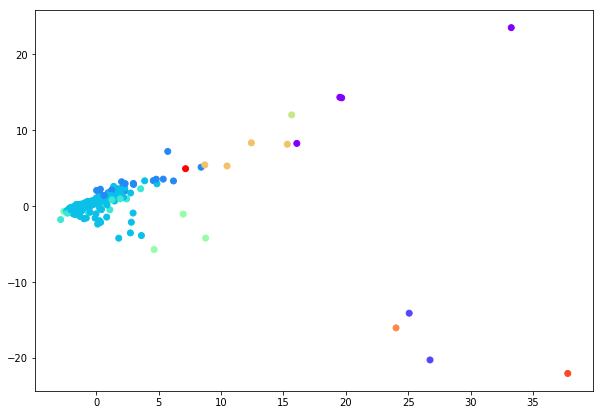

In [586]:
plt.figure(figsize=(10, 7))  
plt.scatter(hcap14[:,0], hcap14[:,1], c=cluster.labels_, cmap='rainbow')  

### HC for 2015 after PCA

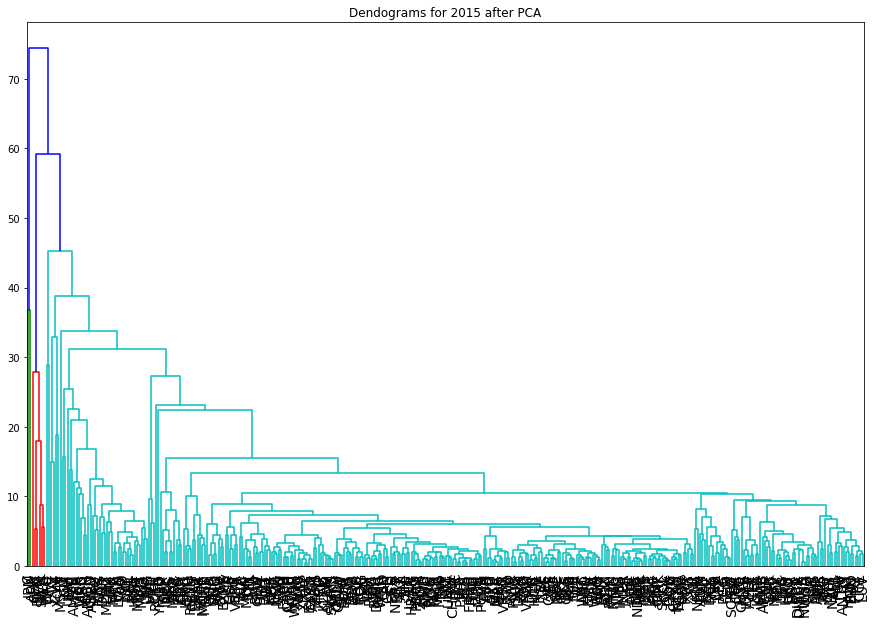

['AAL', 'ABBV', 'ABC', 'ABT', 'ADBE', 'ADM', 'ADS', 'AEE', 'AEP', 'AFL', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALK', 'ALL', 'ALLE', 'ALXN', 'AME', 'AMG', 'AMGN', 'AMP', 'AMT', 'AMZN', 'AN', 'ANTM', 'AON', 'APA', 'APC', 'APD', 'APH', 'ARNC', 'ATVI', 'AVB', 'AWK', 'AXP', 'AYI', 'BA', 'BAC', 'BAX', 'BBT', 'BCR', 'BDX', 'BHI', 'BIIB', 'BK', 'BLL', 'BMY', 'BSX', 'BWA', 'BXP', 'C', 'CAH', 'CAT', 'CB', 'CBG', 'CCI', 'CCL', 'CELG', 'CF', 'CFG', 'CHD', 'CHK', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COG', 'COL', 'CTL', 'CTSH', 'CTXS', 'CVS', 'CVX', 'CXO', 'D', 'DAL', 'DD', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DISCA', 'DISCK', 'DLPH', 'DLR', 'DNB', 'DOV', 'DPS', 'DUK', 'DVA', 'DVN', 'EA', 'EBAY', 'ECL', 'ED', 'EFX', 'EIX', 'EL', 'EMN', 'EMR', 'EOG', 'EQIX', 'EQR', 'EQT', 'ES', 'ESS', 'ETFC', 'ETN', 'ETR', 'EW', 'EXC', 'EXPD', 'EXPE', 'EXR', 'F', 'FAST', 'FB', 'FBHS', 'FCX', 'FE', 'FFIV', 'FIS', 'FISV', 'FLIR', 'FLR', 'FLS', 'FMC', 'F

In [587]:
hcap15 = pca2015.iloc[:,0:20].values

plt.figure(figsize=(15, 10))  
plt.title("Dendograms for 2015 after PCA")
mergings = linkage(hcap15, method='complete')#ward)
labels=pcaname2015
#labels = fcluster(mergings, 70, criterion='distance')
dendrogram(mergings,
           labels=pcaname2015,
           leaf_rotation=90,
           leaf_font_size=14)

plt.show()

print(labels)

In [588]:
from sklearn.cluster import AgglomerativeClustering


cluster = AgglomerativeClustering(n_clusters=12, affinity='euclidean', 
                                  linkage='ward')  
cluster.fit_predict(hcap15) 

array([ 8,  8,  8,  8,  2,  8,  2,  2,  2,  2,  7,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  8,  2,  2,  8,  2,  8,  2,  6,  3,  2,  2,  2,
        2,  2,  2,  2,  2,  8,  1,  2,  2,  2,  2,  2,  2,  2,  2,  8,  2,
        2,  2,  9,  8,  8,  2,  2,  2,  2,  2,  2,  2,  2,  3,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  8,
        4,  2,  2,  8,  8,  2,  2,  2,  2,  8,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  3,  2,  2,  2,  2,  2,  2,  2,  2,  8,  3,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  0,  2, 10,  2,  3,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2, 10,  8,  2,  8,  2,  0,  2,  2,  2,  2,
        2,  2,  8,  2,  2,  3,  2,  2,  8,  2,  2,  2,  2,  2,  0,  2,  2,
        2,  2,  2,  2,  2,  2,  8,  2,  2,  2, 11,  2,  2,  2,  2,  8,  0,
        2,  2,  2,  2,  2,  2,  8,  8,  2,  8,  8,  2,  2,  8,  2,  2,  2,
        2,  2,  2,  2, 10,  8,  2,  8,  7,  2,  2,  2,  2,  2,  8, 10,  8,
        8,  2,  8,  0,  3

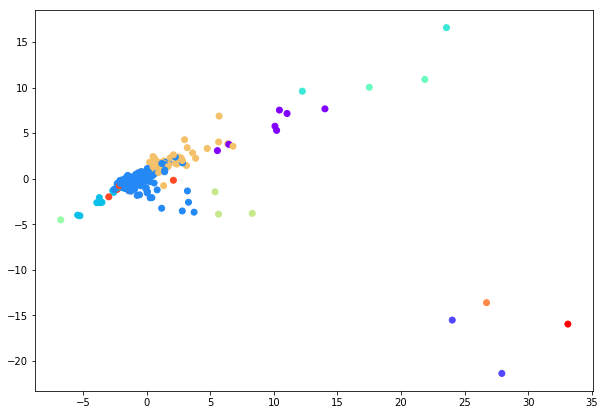

In [589]:
plt.figure(figsize=(10, 7))  
plt.scatter(hcap15[:,0], hcap15[:,1], c=cluster.labels_, cmap='rainbow')  

### HC for 2016 after PCA

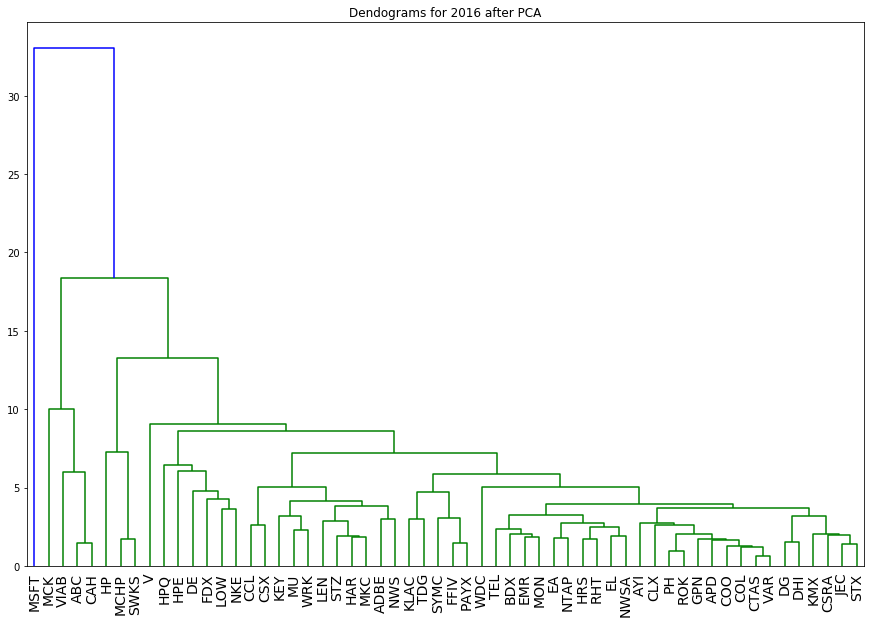

['ABC', 'ADBE', 'APD', 'AYI', 'BDX', 'CAH', 'CCL', 'CLX', 'COL', 'COO', 'CSRA', 'CSX', 'CTAS', 'DE', 'DG', 'DHI', 'EA', 'EL', 'EMR', 'FDX', 'FFIV', 'GPN', 'HAR', 'HP', 'HPE', 'HPQ', 'HRS', 'JEC', 'KEY', 'KLAC', 'KMX', 'LEN', 'LOW', 'MCHP', 'MCK', 'MKC', 'MON', 'MSFT', 'MU', 'NKE', 'NTAP', 'NWS', 'NWSA', 'PAYX', 'PH', 'RHT', 'ROK', 'STX', 'STZ', 'SWKS', 'SYMC', 'TDG', 'TEL', 'V', 'VAR', 'VIAB', 'WDC', 'WRK']


In [590]:
hcap16 = pca2016.iloc[:,0:20].values

plt.figure(figsize=(15, 10))  
plt.title("Dendograms for 2016 after PCA")
mergings = linkage(hcap16, method='complete')#ward)
labels=pcaname2016
#labels = fcluster(mergings, 70, criterion='distance')
dendrogram(mergings,
           labels=pcaname2016,
           leaf_rotation=90,
           leaf_font_size=14)

plt.show()

print(labels)

In [603]:
from sklearn.cluster import AgglomerativeClustering


cluster = AgglomerativeClustering(n_clusters=10, affinity='euclidean', 
                                  linkage='ward')  
cluster.fit_predict(hcap16) 

array([5, 2, 1, 1, 1, 5, 2, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       2, 3, 0, 0, 1, 1, 2, 3, 1, 2, 0, 4, 6, 2, 1, 7, 2, 0, 1, 2, 1, 1,
       1, 1, 1, 1, 2, 4, 1, 3, 1, 8, 1, 9, 1, 2])

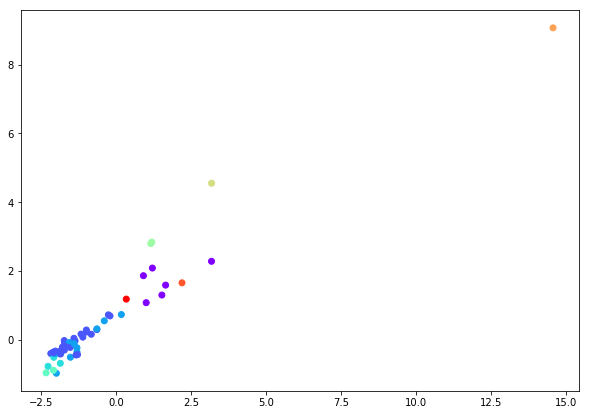

In [604]:
plt.figure(figsize=(10, 7))  
plt.scatter(hcap16[:,0], hcap16[:,1], c=cluster.labels_, cmap='rainbow')  

------------